In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

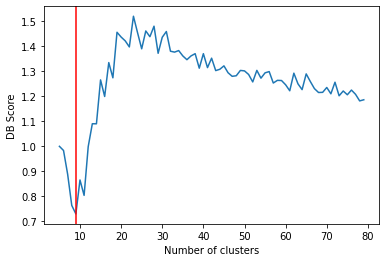

{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

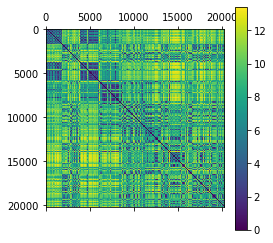

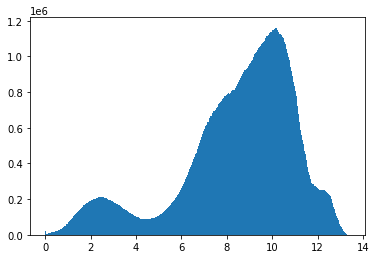

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

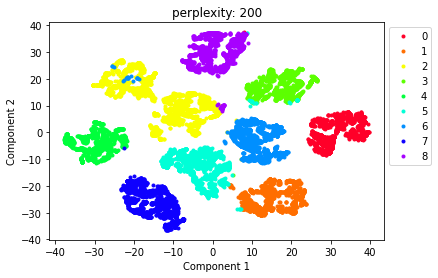

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9906864436012418


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.22331135270005348
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.6799033149171271
layer 6: 0.5408321823204421
layer 7: 0.3476778314917127
layer 8: 0.2008805248618785
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.195 | Reg loss: 0.018 | Tree loss: 2.195 | Accuracy: 0.177000 | 1.219 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.182 | Reg loss: 0.018 | Tree loss: 2.182 | Accuracy: 0.300500 | 1.028 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.167 | Reg loss: 0.018 | Tree loss: 2.167 | Accuracy: 0.349500 | 0.965 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.147 | Reg loss: 0.017 | Tree loss: 2.147 | Accuracy: 0.345500 | 0.935 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.135 | Reg loss: 0.017 | Tree loss: 2.135 | Accuracy: 0.283000 | 0.917 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.131 | Reg loss: 0.017 | Tree loss: 2.131 | Accu

Epoch: 05 | Batch: 000 / 011 | Total loss: 2.138 | Reg loss: 0.015 | Tree loss: 2.138 | Accuracy: 0.342000 | 0.856 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.118 | Reg loss: 0.015 | Tree loss: 2.118 | Accuracy: 0.360000 | 0.855 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 2.096 | Reg loss: 0.015 | Tree loss: 2.096 | Accuracy: 0.407000 | 0.855 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 2.073 | Reg loss: 0.015 | Tree loss: 2.073 | Accuracy: 0.370500 | 0.855 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.049 | Reg loss: 0.016 | Tree loss: 2.049 | Accuracy: 0.361000 | 0.855 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.024 | Reg loss: 0.016 | Tree loss: 2.024 | Accuracy: 0.371500 | 0.855 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 2.005 | Reg loss: 0.016 | Tree loss: 2.005 | Accuracy: 0.364500 | 0.855 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 2.001 | Reg loss: 0.016 | Tree loss: 2.001 | Accuracy: 0.314000 | 0.855 sec/iter
Epoch: 0

Epoch: 10 | Batch: 000 / 011 | Total loss: 2.030 | Reg loss: 0.018 | Tree loss: 2.030 | Accuracy: 0.551500 | 0.851 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 1.992 | Reg loss: 0.018 | Tree loss: 1.992 | Accuracy: 0.552000 | 0.851 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 1.957 | Reg loss: 0.018 | Tree loss: 1.957 | Accuracy: 0.512000 | 0.851 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.912 | Reg loss: 0.019 | Tree loss: 1.912 | Accuracy: 0.495500 | 0.851 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.863 | Reg loss: 0.019 | Tree loss: 1.863 | Accuracy: 0.488500 | 0.851 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.833 | Reg loss: 0.019 | Tree loss: 1.833 | Accuracy: 0.452500 | 0.851 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 1.809 | Reg loss: 0.019 | Tree loss: 1.809 | Accuracy: 0.430000 | 0.851 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 1.783 | Reg loss: 0.019 | Tree loss: 1.783 | Accuracy: 0.429500 | 0.851 sec/iter
Epoch: 1

Epoch: 15 | Batch: 000 / 011 | Total loss: 1.855 | Reg loss: 0.022 | Tree loss: 1.855 | Accuracy: 0.498000 | 0.849 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 1.809 | Reg loss: 0.022 | Tree loss: 1.809 | Accuracy: 0.524500 | 0.849 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 1.761 | Reg loss: 0.022 | Tree loss: 1.761 | Accuracy: 0.525500 | 0.849 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 1.696 | Reg loss: 0.022 | Tree loss: 1.696 | Accuracy: 0.545000 | 0.849 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 1.671 | Reg loss: 0.022 | Tree loss: 1.671 | Accuracy: 0.499500 | 0.849 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.623 | Reg loss: 0.022 | Tree loss: 1.623 | Accuracy: 0.487500 | 0.849 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 1.589 | Reg loss: 0.022 | Tree loss: 1.589 | Accuracy: 0.481000 | 0.849 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 1.596 | Reg loss: 0.022 | Tree loss: 1.596 | Accuracy: 0.446500 | 0.849 sec/iter
Epoch: 1

Epoch: 20 | Batch: 000 / 011 | Total loss: 1.694 | Reg loss: 0.024 | Tree loss: 1.694 | Accuracy: 0.533500 | 0.848 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 1.642 | Reg loss: 0.024 | Tree loss: 1.642 | Accuracy: 0.528000 | 0.848 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 1.608 | Reg loss: 0.024 | Tree loss: 1.608 | Accuracy: 0.531000 | 0.848 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 1.550 | Reg loss: 0.024 | Tree loss: 1.550 | Accuracy: 0.505500 | 0.848 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 1.509 | Reg loss: 0.024 | Tree loss: 1.509 | Accuracy: 0.500500 | 0.848 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 1.482 | Reg loss: 0.024 | Tree loss: 1.482 | Accuracy: 0.516500 | 0.848 sec/iter
Epoch: 20 | Batch: 006 / 011 | Total loss: 1.463 | Reg loss: 0.024 | Tree loss: 1.463 | Accuracy: 0.513000 | 0.848 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 1.439 | Reg loss: 0.024 | Tree loss: 1.439 | Accuracy: 0.514500 | 0.848 sec/iter
Epoch: 2

Epoch: 25 | Batch: 000 / 011 | Total loss: 1.578 | Reg loss: 0.025 | Tree loss: 1.578 | Accuracy: 0.547500 | 0.848 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 1.534 | Reg loss: 0.025 | Tree loss: 1.534 | Accuracy: 0.516000 | 0.848 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 1.481 | Reg loss: 0.025 | Tree loss: 1.481 | Accuracy: 0.519500 | 0.848 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 1.441 | Reg loss: 0.025 | Tree loss: 1.441 | Accuracy: 0.502500 | 0.848 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 1.402 | Reg loss: 0.025 | Tree loss: 1.402 | Accuracy: 0.502500 | 0.848 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 1.376 | Reg loss: 0.025 | Tree loss: 1.376 | Accuracy: 0.504000 | 0.848 sec/iter
Epoch: 25 | Batch: 006 / 011 | Total loss: 1.358 | Reg loss: 0.025 | Tree loss: 1.358 | Accuracy: 0.501500 | 0.848 sec/iter
Epoch: 25 | Batch: 007 / 011 | Total loss: 1.340 | Reg loss: 0.025 | Tree loss: 1.340 | Accuracy: 0.515500 | 0.848 sec/iter
Epoch: 2

Epoch: 30 | Batch: 000 / 011 | Total loss: 1.470 | Reg loss: 0.026 | Tree loss: 1.470 | Accuracy: 0.567500 | 0.848 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 1.438 | Reg loss: 0.026 | Tree loss: 1.438 | Accuracy: 0.537000 | 0.848 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 1.392 | Reg loss: 0.026 | Tree loss: 1.392 | Accuracy: 0.529500 | 0.848 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 1.354 | Reg loss: 0.026 | Tree loss: 1.354 | Accuracy: 0.515000 | 0.848 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 1.317 | Reg loss: 0.026 | Tree loss: 1.317 | Accuracy: 0.514500 | 0.848 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 1.288 | Reg loss: 0.026 | Tree loss: 1.288 | Accuracy: 0.523000 | 0.848 sec/iter
Epoch: 30 | Batch: 006 / 011 | Total loss: 1.269 | Reg loss: 0.026 | Tree loss: 1.269 | Accuracy: 0.546000 | 0.848 sec/iter
Epoch: 30 | Batch: 007 / 011 | Total loss: 1.259 | Reg loss: 0.027 | Tree loss: 1.259 | Accuracy: 0.555000 | 0.848 sec/iter
Epoch: 3

Epoch: 35 | Batch: 000 / 011 | Total loss: 1.376 | Reg loss: 0.027 | Tree loss: 1.376 | Accuracy: 0.572500 | 0.848 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 1.357 | Reg loss: 0.027 | Tree loss: 1.357 | Accuracy: 0.554500 | 0.848 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 1.301 | Reg loss: 0.027 | Tree loss: 1.301 | Accuracy: 0.549000 | 0.848 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 1.291 | Reg loss: 0.027 | Tree loss: 1.291 | Accuracy: 0.539000 | 0.848 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 1.269 | Reg loss: 0.027 | Tree loss: 1.269 | Accuracy: 0.560000 | 0.848 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 1.232 | Reg loss: 0.027 | Tree loss: 1.232 | Accuracy: 0.574000 | 0.848 sec/iter
Epoch: 35 | Batch: 006 / 011 | Total loss: 1.219 | Reg loss: 0.027 | Tree loss: 1.219 | Accuracy: 0.589000 | 0.848 sec/iter
Epoch: 35 | Batch: 007 / 011 | Total loss: 1.206 | Reg loss: 0.027 | Tree loss: 1.206 | Accuracy: 0.584000 | 0.848 sec/iter
Epoch: 3

Epoch: 40 | Batch: 000 / 011 | Total loss: 1.322 | Reg loss: 0.028 | Tree loss: 1.322 | Accuracy: 0.578000 | 0.848 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 1.290 | Reg loss: 0.028 | Tree loss: 1.290 | Accuracy: 0.586500 | 0.848 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 1.274 | Reg loss: 0.028 | Tree loss: 1.274 | Accuracy: 0.566500 | 0.848 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 1.238 | Reg loss: 0.028 | Tree loss: 1.238 | Accuracy: 0.589000 | 0.848 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 1.199 | Reg loss: 0.028 | Tree loss: 1.199 | Accuracy: 0.609000 | 0.848 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 1.185 | Reg loss: 0.028 | Tree loss: 1.185 | Accuracy: 0.592000 | 0.848 sec/iter
Epoch: 40 | Batch: 006 / 011 | Total loss: 1.173 | Reg loss: 0.028 | Tree loss: 1.173 | Accuracy: 0.608500 | 0.848 sec/iter
Epoch: 40 | Batch: 007 / 011 | Total loss: 1.160 | Reg loss: 0.028 | Tree loss: 1.160 | Accuracy: 0.618000 | 0.848 sec/iter
Epoch: 4

Epoch: 45 | Batch: 000 / 011 | Total loss: 1.277 | Reg loss: 0.029 | Tree loss: 1.277 | Accuracy: 0.591500 | 0.848 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 1.252 | Reg loss: 0.029 | Tree loss: 1.252 | Accuracy: 0.602500 | 0.848 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 1.212 | Reg loss: 0.029 | Tree loss: 1.212 | Accuracy: 0.607500 | 0.848 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 1.192 | Reg loss: 0.029 | Tree loss: 1.192 | Accuracy: 0.596000 | 0.848 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 1.161 | Reg loss: 0.029 | Tree loss: 1.161 | Accuracy: 0.604000 | 0.848 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 1.178 | Reg loss: 0.029 | Tree loss: 1.178 | Accuracy: 0.594500 | 0.848 sec/iter
Epoch: 45 | Batch: 006 / 011 | Total loss: 1.132 | Reg loss: 0.029 | Tree loss: 1.132 | Accuracy: 0.597500 | 0.848 sec/iter
Epoch: 45 | Batch: 007 / 011 | Total loss: 1.126 | Reg loss: 0.029 | Tree loss: 1.126 | Accuracy: 0.607500 | 0.848 sec/iter
Epoch: 4

Epoch: 50 | Batch: 000 / 011 | Total loss: 1.230 | Reg loss: 0.029 | Tree loss: 1.230 | Accuracy: 0.598500 | 0.848 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 1.202 | Reg loss: 0.029 | Tree loss: 1.202 | Accuracy: 0.599000 | 0.848 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 1.197 | Reg loss: 0.029 | Tree loss: 1.197 | Accuracy: 0.599000 | 0.848 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 1.162 | Reg loss: 0.029 | Tree loss: 1.162 | Accuracy: 0.591500 | 0.848 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 1.131 | Reg loss: 0.029 | Tree loss: 1.131 | Accuracy: 0.589500 | 0.848 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 1.119 | Reg loss: 0.029 | Tree loss: 1.119 | Accuracy: 0.581500 | 0.848 sec/iter
Epoch: 50 | Batch: 006 / 011 | Total loss: 1.108 | Reg loss: 0.029 | Tree loss: 1.108 | Accuracy: 0.600500 | 0.848 sec/iter
Epoch: 50 | Batch: 007 / 011 | Total loss: 1.100 | Reg loss: 0.029 | Tree loss: 1.100 | Accuracy: 0.594500 | 0.848 sec/iter
Epoch: 5

Epoch: 55 | Batch: 000 / 011 | Total loss: 1.214 | Reg loss: 0.030 | Tree loss: 1.214 | Accuracy: 0.592000 | 0.848 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 1.167 | Reg loss: 0.030 | Tree loss: 1.167 | Accuracy: 0.611500 | 0.848 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 1.162 | Reg loss: 0.030 | Tree loss: 1.162 | Accuracy: 0.594000 | 0.848 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 1.130 | Reg loss: 0.030 | Tree loss: 1.130 | Accuracy: 0.599000 | 0.848 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 1.103 | Reg loss: 0.030 | Tree loss: 1.103 | Accuracy: 0.598000 | 0.848 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 1.087 | Reg loss: 0.030 | Tree loss: 1.087 | Accuracy: 0.587500 | 0.848 sec/iter
Epoch: 55 | Batch: 006 / 011 | Total loss: 1.087 | Reg loss: 0.030 | Tree loss: 1.087 | Accuracy: 0.600500 | 0.848 sec/iter
Epoch: 55 | Batch: 007 / 011 | Total loss: 1.041 | Reg loss: 0.030 | Tree loss: 1.041 | Accuracy: 0.623500 | 0.848 sec/iter
Epoch: 5

Epoch: 60 | Batch: 000 / 011 | Total loss: 1.167 | Reg loss: 0.030 | Tree loss: 1.167 | Accuracy: 0.580000 | 0.848 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 1.162 | Reg loss: 0.030 | Tree loss: 1.162 | Accuracy: 0.582500 | 0.848 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 1.137 | Reg loss: 0.030 | Tree loss: 1.137 | Accuracy: 0.601500 | 0.848 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 1.088 | Reg loss: 0.030 | Tree loss: 1.088 | Accuracy: 0.624500 | 0.848 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 1.069 | Reg loss: 0.030 | Tree loss: 1.069 | Accuracy: 0.618500 | 0.848 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 1.046 | Reg loss: 0.030 | Tree loss: 1.046 | Accuracy: 0.628000 | 0.848 sec/iter
Epoch: 60 | Batch: 006 / 011 | Total loss: 1.055 | Reg loss: 0.030 | Tree loss: 1.055 | Accuracy: 0.617000 | 0.848 sec/iter
Epoch: 60 | Batch: 007 / 011 | Total loss: 1.052 | Reg loss: 0.030 | Tree loss: 1.052 | Accuracy: 0.645500 | 0.848 sec/iter
Epoch: 6

Epoch: 65 | Batch: 000 / 011 | Total loss: 1.131 | Reg loss: 0.031 | Tree loss: 1.131 | Accuracy: 0.577500 | 0.848 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 1.133 | Reg loss: 0.031 | Tree loss: 1.133 | Accuracy: 0.583500 | 0.848 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 1.104 | Reg loss: 0.031 | Tree loss: 1.104 | Accuracy: 0.597500 | 0.848 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 1.062 | Reg loss: 0.031 | Tree loss: 1.062 | Accuracy: 0.623500 | 0.848 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 1.064 | Reg loss: 0.031 | Tree loss: 1.064 | Accuracy: 0.609500 | 0.848 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 1.046 | Reg loss: 0.031 | Tree loss: 1.046 | Accuracy: 0.632500 | 0.848 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 1.011 | Reg loss: 0.031 | Tree loss: 1.011 | Accuracy: 0.659500 | 0.848 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 1.031 | Reg loss: 0.031 | Tree loss: 1.031 | Accuracy: 0.632500 | 0.848 sec/iter
Epoch: 6

Epoch: 70 | Batch: 000 / 011 | Total loss: 1.115 | Reg loss: 0.031 | Tree loss: 1.115 | Accuracy: 0.574000 | 0.848 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 1.090 | Reg loss: 0.031 | Tree loss: 1.090 | Accuracy: 0.594500 | 0.847 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 1.078 | Reg loss: 0.031 | Tree loss: 1.078 | Accuracy: 0.606000 | 0.847 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 1.060 | Reg loss: 0.031 | Tree loss: 1.060 | Accuracy: 0.615000 | 0.847 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 1.072 | Reg loss: 0.031 | Tree loss: 1.072 | Accuracy: 0.596500 | 0.847 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 1.025 | Reg loss: 0.031 | Tree loss: 1.025 | Accuracy: 0.627000 | 0.847 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 1.017 | Reg loss: 0.031 | Tree loss: 1.017 | Accuracy: 0.646000 | 0.847 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 1.011 | Reg loss: 0.031 | Tree loss: 1.011 | Accuracy: 0.657500 | 0.847 sec/iter
Epoch: 7

Epoch: 75 | Batch: 000 / 011 | Total loss: 1.131 | Reg loss: 0.031 | Tree loss: 1.131 | Accuracy: 0.560500 | 0.848 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 1.088 | Reg loss: 0.031 | Tree loss: 1.088 | Accuracy: 0.578500 | 0.847 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 1.069 | Reg loss: 0.032 | Tree loss: 1.069 | Accuracy: 0.587000 | 0.847 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 1.033 | Reg loss: 0.032 | Tree loss: 1.033 | Accuracy: 0.612500 | 0.847 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 1.039 | Reg loss: 0.032 | Tree loss: 1.039 | Accuracy: 0.613500 | 0.847 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 0.997 | Reg loss: 0.032 | Tree loss: 0.997 | Accuracy: 0.637500 | 0.847 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 0.991 | Reg loss: 0.032 | Tree loss: 0.991 | Accuracy: 0.662000 | 0.847 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 0.978 | Reg loss: 0.032 | Tree loss: 0.978 | Accuracy: 0.667500 | 0.847 sec/iter
Epoch: 7

Epoch: 80 | Batch: 000 / 011 | Total loss: 1.084 | Reg loss: 0.032 | Tree loss: 1.084 | Accuracy: 0.568500 | 0.847 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 1.075 | Reg loss: 0.032 | Tree loss: 1.075 | Accuracy: 0.575000 | 0.847 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 1.051 | Reg loss: 0.032 | Tree loss: 1.051 | Accuracy: 0.595000 | 0.847 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 1.025 | Reg loss: 0.032 | Tree loss: 1.025 | Accuracy: 0.618500 | 0.847 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 1.018 | Reg loss: 0.032 | Tree loss: 1.018 | Accuracy: 0.627500 | 0.847 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 0.981 | Reg loss: 0.032 | Tree loss: 0.981 | Accuracy: 0.659500 | 0.847 sec/iter
Epoch: 80 | Batch: 006 / 011 | Total loss: 0.989 | Reg loss: 0.032 | Tree loss: 0.989 | Accuracy: 0.668000 | 0.847 sec/iter
Epoch: 80 | Batch: 007 / 011 | Total loss: 0.969 | Reg loss: 0.032 | Tree loss: 0.969 | Accuracy: 0.668000 | 0.847 sec/iter
Epoch: 8

Epoch: 85 | Batch: 000 / 011 | Total loss: 1.070 | Reg loss: 0.033 | Tree loss: 1.070 | Accuracy: 0.567000 | 0.847 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 1.048 | Reg loss: 0.033 | Tree loss: 1.048 | Accuracy: 0.591000 | 0.847 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 1.049 | Reg loss: 0.033 | Tree loss: 1.049 | Accuracy: 0.568500 | 0.847 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 1.024 | Reg loss: 0.033 | Tree loss: 1.024 | Accuracy: 0.607500 | 0.847 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 0.976 | Reg loss: 0.033 | Tree loss: 0.976 | Accuracy: 0.656500 | 0.847 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 0.985 | Reg loss: 0.033 | Tree loss: 0.985 | Accuracy: 0.659000 | 0.847 sec/iter
Epoch: 85 | Batch: 006 / 011 | Total loss: 0.952 | Reg loss: 0.033 | Tree loss: 0.952 | Accuracy: 0.679500 | 0.847 sec/iter
Epoch: 85 | Batch: 007 / 011 | Total loss: 0.953 | Reg loss: 0.033 | Tree loss: 0.953 | Accuracy: 0.661500 | 0.847 sec/iter
Epoch: 8

Epoch: 90 | Batch: 000 / 011 | Total loss: 1.040 | Reg loss: 0.033 | Tree loss: 1.040 | Accuracy: 0.572500 | 0.847 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 1.039 | Reg loss: 0.033 | Tree loss: 1.039 | Accuracy: 0.591500 | 0.847 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 1.012 | Reg loss: 0.033 | Tree loss: 1.012 | Accuracy: 0.585500 | 0.847 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 1.001 | Reg loss: 0.033 | Tree loss: 1.001 | Accuracy: 0.590000 | 0.847 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 0.985 | Reg loss: 0.033 | Tree loss: 0.985 | Accuracy: 0.634000 | 0.847 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 0.976 | Reg loss: 0.033 | Tree loss: 0.976 | Accuracy: 0.657500 | 0.847 sec/iter
Epoch: 90 | Batch: 006 / 011 | Total loss: 0.941 | Reg loss: 0.033 | Tree loss: 0.941 | Accuracy: 0.687500 | 0.847 sec/iter
Epoch: 90 | Batch: 007 / 011 | Total loss: 0.939 | Reg loss: 0.033 | Tree loss: 0.939 | Accuracy: 0.683500 | 0.847 sec/iter
Epoch: 9

Epoch: 95 | Batch: 000 / 011 | Total loss: 1.036 | Reg loss: 0.034 | Tree loss: 1.036 | Accuracy: 0.568000 | 0.848 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 1.047 | Reg loss: 0.034 | Tree loss: 1.047 | Accuracy: 0.559500 | 0.848 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 0.998 | Reg loss: 0.034 | Tree loss: 0.998 | Accuracy: 0.595000 | 0.848 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 0.995 | Reg loss: 0.034 | Tree loss: 0.995 | Accuracy: 0.633500 | 0.848 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 0.965 | Reg loss: 0.034 | Tree loss: 0.965 | Accuracy: 0.643000 | 0.848 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 0.959 | Reg loss: 0.034 | Tree loss: 0.959 | Accuracy: 0.672000 | 0.848 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 0.954 | Reg loss: 0.034 | Tree loss: 0.954 | Accuracy: 0.672000 | 0.848 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 0.947 | Reg loss: 0.034 | Tree loss: 0.947 | Accuracy: 0.652500 | 0.848 sec/iter
Epoch: 9

Epoch: 100 | Batch: 000 / 011 | Total loss: 1.037 | Reg loss: 0.034 | Tree loss: 1.037 | Accuracy: 0.571500 | 0.848 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 1.012 | Reg loss: 0.034 | Tree loss: 1.012 | Accuracy: 0.580000 | 0.848 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 0.991 | Reg loss: 0.034 | Tree loss: 0.991 | Accuracy: 0.594000 | 0.848 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 0.988 | Reg loss: 0.034 | Tree loss: 0.988 | Accuracy: 0.587000 | 0.848 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 0.947 | Reg loss: 0.034 | Tree loss: 0.947 | Accuracy: 0.621500 | 0.848 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 0.954 | Reg loss: 0.034 | Tree loss: 0.954 | Accuracy: 0.653500 | 0.848 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 0.924 | Reg loss: 0.034 | Tree loss: 0.924 | Accuracy: 0.681500 | 0.848 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 0.955 | Reg loss: 0.034 | Tree loss: 0.955 | Accuracy: 0.661000 | 0.848 sec/iter


Epoch: 105 | Batch: 000 / 011 | Total loss: 1.035 | Reg loss: 0.035 | Tree loss: 1.035 | Accuracy: 0.568000 | 0.848 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 0.998 | Reg loss: 0.035 | Tree loss: 0.998 | Accuracy: 0.578500 | 0.848 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 0.974 | Reg loss: 0.035 | Tree loss: 0.974 | Accuracy: 0.594000 | 0.848 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 0.981 | Reg loss: 0.035 | Tree loss: 0.981 | Accuracy: 0.620500 | 0.848 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 0.946 | Reg loss: 0.035 | Tree loss: 0.946 | Accuracy: 0.655500 | 0.848 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 0.909 | Reg loss: 0.035 | Tree loss: 0.909 | Accuracy: 0.695000 | 0.848 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.953 | Reg loss: 0.035 | Tree loss: 0.953 | Accuracy: 0.656500 | 0.848 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.916 | Reg loss: 0.035 | Tree loss: 0.916 | Accuracy: 0.671500 | 0.848 sec/iter


Epoch: 110 | Batch: 000 / 011 | Total loss: 0.989 | Reg loss: 0.035 | Tree loss: 0.989 | Accuracy: 0.590000 | 0.848 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.035 | Tree loss: 1.000 | Accuracy: 0.579500 | 0.848 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.980 | Reg loss: 0.035 | Tree loss: 0.980 | Accuracy: 0.590500 | 0.848 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.985 | Reg loss: 0.035 | Tree loss: 0.985 | Accuracy: 0.597000 | 0.848 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.935 | Reg loss: 0.035 | Tree loss: 0.935 | Accuracy: 0.651000 | 0.848 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.940 | Reg loss: 0.035 | Tree loss: 0.940 | Accuracy: 0.671000 | 0.848 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.903 | Reg loss: 0.035 | Tree loss: 0.903 | Accuracy: 0.684500 | 0.848 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.906 | Reg loss: 0.035 | Tree loss: 0.906 | Accuracy: 0.673000 | 0.848 sec/iter


Epoch: 115 | Batch: 000 / 011 | Total loss: 1.027 | Reg loss: 0.036 | Tree loss: 1.027 | Accuracy: 0.573500 | 0.848 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.977 | Reg loss: 0.036 | Tree loss: 0.977 | Accuracy: 0.616500 | 0.848 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.986 | Reg loss: 0.036 | Tree loss: 0.986 | Accuracy: 0.586500 | 0.848 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.961 | Reg loss: 0.036 | Tree loss: 0.961 | Accuracy: 0.627500 | 0.848 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.928 | Reg loss: 0.036 | Tree loss: 0.928 | Accuracy: 0.680000 | 0.848 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.927 | Reg loss: 0.036 | Tree loss: 0.927 | Accuracy: 0.692500 | 0.848 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.885 | Reg loss: 0.036 | Tree loss: 0.885 | Accuracy: 0.704000 | 0.848 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 0.924 | Reg loss: 0.036 | Tree loss: 0.924 | Accuracy: 0.660000 | 0.848 sec/iter


Epoch: 120 | Batch: 000 / 011 | Total loss: 1.001 | Reg loss: 0.036 | Tree loss: 1.001 | Accuracy: 0.582500 | 0.848 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.989 | Reg loss: 0.036 | Tree loss: 0.989 | Accuracy: 0.578500 | 0.848 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.982 | Reg loss: 0.036 | Tree loss: 0.982 | Accuracy: 0.573000 | 0.848 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.969 | Reg loss: 0.036 | Tree loss: 0.969 | Accuracy: 0.600000 | 0.848 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 0.928 | Reg loss: 0.036 | Tree loss: 0.928 | Accuracy: 0.634500 | 0.848 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 0.916 | Reg loss: 0.036 | Tree loss: 0.916 | Accuracy: 0.670000 | 0.848 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 0.910 | Reg loss: 0.036 | Tree loss: 0.910 | Accuracy: 0.677000 | 0.848 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 0.891 | Reg loss: 0.036 | Tree loss: 0.891 | Accuracy: 0.680000 | 0.848 sec/iter


Epoch: 125 | Batch: 000 / 011 | Total loss: 1.010 | Reg loss: 0.037 | Tree loss: 1.010 | Accuracy: 0.573500 | 0.848 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 1.008 | Reg loss: 0.037 | Tree loss: 1.008 | Accuracy: 0.574000 | 0.848 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 0.971 | Reg loss: 0.037 | Tree loss: 0.971 | Accuracy: 0.607000 | 0.848 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 0.932 | Reg loss: 0.037 | Tree loss: 0.932 | Accuracy: 0.615500 | 0.848 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 0.922 | Reg loss: 0.037 | Tree loss: 0.922 | Accuracy: 0.665500 | 0.848 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 0.909 | Reg loss: 0.037 | Tree loss: 0.909 | Accuracy: 0.680500 | 0.848 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 0.857 | Reg loss: 0.037 | Tree loss: 0.857 | Accuracy: 0.710000 | 0.848 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 0.893 | Reg loss: 0.037 | Tree loss: 0.893 | Accuracy: 0.677000 | 0.848 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 0.986 | Reg loss: 0.037 | Tree loss: 0.986 | Accuracy: 0.596000 | 0.848 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 0.989 | Reg loss: 0.037 | Tree loss: 0.989 | Accuracy: 0.595500 | 0.848 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 0.976 | Reg loss: 0.037 | Tree loss: 0.976 | Accuracy: 0.607000 | 0.848 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 0.949 | Reg loss: 0.037 | Tree loss: 0.949 | Accuracy: 0.612500 | 0.848 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 0.915 | Reg loss: 0.037 | Tree loss: 0.915 | Accuracy: 0.644000 | 0.848 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 0.906 | Reg loss: 0.037 | Tree loss: 0.906 | Accuracy: 0.673500 | 0.848 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 0.894 | Reg loss: 0.037 | Tree loss: 0.894 | Accuracy: 0.696500 | 0.848 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 0.925 | Reg loss: 0.037 | Tree loss: 0.925 | Accuracy: 0.662500 | 0.848 sec/iter


Epoch: 135 | Batch: 000 / 011 | Total loss: 0.986 | Reg loss: 0.037 | Tree loss: 0.986 | Accuracy: 0.591000 | 0.848 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 0.971 | Reg loss: 0.037 | Tree loss: 0.971 | Accuracy: 0.597500 | 0.848 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 0.965 | Reg loss: 0.037 | Tree loss: 0.965 | Accuracy: 0.601000 | 0.848 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 0.943 | Reg loss: 0.037 | Tree loss: 0.943 | Accuracy: 0.627500 | 0.848 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 0.897 | Reg loss: 0.037 | Tree loss: 0.897 | Accuracy: 0.673500 | 0.848 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 0.905 | Reg loss: 0.037 | Tree loss: 0.905 | Accuracy: 0.681000 | 0.848 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 0.894 | Reg loss: 0.037 | Tree loss: 0.894 | Accuracy: 0.688000 | 0.848 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 0.906 | Reg loss: 0.037 | Tree loss: 0.906 | Accuracy: 0.659500 | 0.848 sec/iter


Epoch: 140 | Batch: 000 / 011 | Total loss: 0.984 | Reg loss: 0.038 | Tree loss: 0.984 | Accuracy: 0.608000 | 0.848 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 0.994 | Reg loss: 0.038 | Tree loss: 0.994 | Accuracy: 0.585500 | 0.848 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 0.934 | Reg loss: 0.038 | Tree loss: 0.934 | Accuracy: 0.618000 | 0.848 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 0.914 | Reg loss: 0.038 | Tree loss: 0.914 | Accuracy: 0.658000 | 0.848 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 0.922 | Reg loss: 0.038 | Tree loss: 0.922 | Accuracy: 0.661500 | 0.848 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 0.897 | Reg loss: 0.038 | Tree loss: 0.897 | Accuracy: 0.683500 | 0.848 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 0.878 | Reg loss: 0.038 | Tree loss: 0.878 | Accuracy: 0.684000 | 0.848 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 0.895 | Reg loss: 0.038 | Tree loss: 0.895 | Accuracy: 0.658500 | 0.848 sec/iter


Epoch: 145 | Batch: 000 / 011 | Total loss: 0.978 | Reg loss: 0.038 | Tree loss: 0.978 | Accuracy: 0.604000 | 0.848 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 0.966 | Reg loss: 0.038 | Tree loss: 0.966 | Accuracy: 0.600000 | 0.848 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 0.955 | Reg loss: 0.038 | Tree loss: 0.955 | Accuracy: 0.610500 | 0.848 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 0.946 | Reg loss: 0.038 | Tree loss: 0.946 | Accuracy: 0.616500 | 0.848 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 0.909 | Reg loss: 0.038 | Tree loss: 0.909 | Accuracy: 0.667500 | 0.848 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 0.855 | Reg loss: 0.038 | Tree loss: 0.855 | Accuracy: 0.700500 | 0.848 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 0.883 | Reg loss: 0.038 | Tree loss: 0.883 | Accuracy: 0.696500 | 0.848 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 0.898 | Reg loss: 0.038 | Tree loss: 0.898 | Accuracy: 0.676000 | 0.848 sec/iter


Epoch: 150 | Batch: 000 / 011 | Total loss: 1.006 | Reg loss: 0.038 | Tree loss: 1.006 | Accuracy: 0.582000 | 0.848 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.953 | Reg loss: 0.038 | Tree loss: 0.953 | Accuracy: 0.603500 | 0.848 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 0.952 | Reg loss: 0.038 | Tree loss: 0.952 | Accuracy: 0.611500 | 0.848 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 0.925 | Reg loss: 0.038 | Tree loss: 0.925 | Accuracy: 0.643000 | 0.848 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 0.894 | Reg loss: 0.038 | Tree loss: 0.894 | Accuracy: 0.691000 | 0.848 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 0.888 | Reg loss: 0.038 | Tree loss: 0.888 | Accuracy: 0.704000 | 0.848 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 0.862 | Reg loss: 0.038 | Tree loss: 0.862 | Accuracy: 0.700500 | 0.848 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 0.874 | Reg loss: 0.038 | Tree loss: 0.874 | Accuracy: 0.685500 | 0.848 sec/iter


Epoch: 155 | Batch: 000 / 011 | Total loss: 0.994 | Reg loss: 0.038 | Tree loss: 0.994 | Accuracy: 0.592000 | 0.848 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.960 | Reg loss: 0.038 | Tree loss: 0.960 | Accuracy: 0.611500 | 0.848 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.946 | Reg loss: 0.038 | Tree loss: 0.946 | Accuracy: 0.634500 | 0.848 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.913 | Reg loss: 0.038 | Tree loss: 0.913 | Accuracy: 0.649500 | 0.848 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.890 | Reg loss: 0.039 | Tree loss: 0.890 | Accuracy: 0.688500 | 0.848 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 0.885 | Reg loss: 0.039 | Tree loss: 0.885 | Accuracy: 0.695500 | 0.848 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 0.905 | Reg loss: 0.039 | Tree loss: 0.905 | Accuracy: 0.653500 | 0.848 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 0.872 | Reg loss: 0.039 | Tree loss: 0.872 | Accuracy: 0.667500 | 0.848 sec/iter


Epoch: 160 | Batch: 000 / 011 | Total loss: 0.982 | Reg loss: 0.039 | Tree loss: 0.982 | Accuracy: 0.603000 | 0.848 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.960 | Reg loss: 0.039 | Tree loss: 0.960 | Accuracy: 0.612000 | 0.848 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.945 | Reg loss: 0.039 | Tree loss: 0.945 | Accuracy: 0.623500 | 0.848 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.936 | Reg loss: 0.039 | Tree loss: 0.936 | Accuracy: 0.644000 | 0.848 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.897 | Reg loss: 0.039 | Tree loss: 0.897 | Accuracy: 0.651500 | 0.848 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.872 | Reg loss: 0.039 | Tree loss: 0.872 | Accuracy: 0.690500 | 0.848 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 0.862 | Reg loss: 0.039 | Tree loss: 0.862 | Accuracy: 0.696500 | 0.848 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 0.874 | Reg loss: 0.039 | Tree loss: 0.874 | Accuracy: 0.684500 | 0.848 sec/iter


Epoch: 165 | Batch: 000 / 011 | Total loss: 0.979 | Reg loss: 0.039 | Tree loss: 0.979 | Accuracy: 0.603000 | 0.848 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.936 | Reg loss: 0.039 | Tree loss: 0.936 | Accuracy: 0.628500 | 0.848 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.963 | Reg loss: 0.039 | Tree loss: 0.963 | Accuracy: 0.598500 | 0.848 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.905 | Reg loss: 0.039 | Tree loss: 0.905 | Accuracy: 0.649000 | 0.848 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.894 | Reg loss: 0.039 | Tree loss: 0.894 | Accuracy: 0.665500 | 0.848 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.872 | Reg loss: 0.039 | Tree loss: 0.872 | Accuracy: 0.692500 | 0.848 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.868 | Reg loss: 0.039 | Tree loss: 0.868 | Accuracy: 0.703000 | 0.848 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.858 | Reg loss: 0.039 | Tree loss: 0.858 | Accuracy: 0.692000 | 0.848 sec/iter


Epoch: 170 | Batch: 000 / 011 | Total loss: 0.990 | Reg loss: 0.039 | Tree loss: 0.990 | Accuracy: 0.592000 | 0.848 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 0.962 | Reg loss: 0.039 | Tree loss: 0.962 | Accuracy: 0.600500 | 0.848 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 0.919 | Reg loss: 0.039 | Tree loss: 0.919 | Accuracy: 0.635000 | 0.848 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.915 | Reg loss: 0.039 | Tree loss: 0.915 | Accuracy: 0.639000 | 0.848 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.866 | Reg loss: 0.039 | Tree loss: 0.866 | Accuracy: 0.696500 | 0.848 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.855 | Reg loss: 0.039 | Tree loss: 0.855 | Accuracy: 0.714000 | 0.848 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.835 | Reg loss: 0.039 | Tree loss: 0.835 | Accuracy: 0.708500 | 0.848 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.843 | Reg loss: 0.039 | Tree loss: 0.843 | Accuracy: 0.707500 | 0.848 sec/iter


Epoch: 175 | Batch: 000 / 011 | Total loss: 0.966 | Reg loss: 0.039 | Tree loss: 0.966 | Accuracy: 0.620500 | 0.848 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 0.957 | Reg loss: 0.040 | Tree loss: 0.957 | Accuracy: 0.609000 | 0.848 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 0.917 | Reg loss: 0.040 | Tree loss: 0.917 | Accuracy: 0.628000 | 0.848 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 0.898 | Reg loss: 0.040 | Tree loss: 0.898 | Accuracy: 0.659000 | 0.848 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 0.882 | Reg loss: 0.040 | Tree loss: 0.882 | Accuracy: 0.671500 | 0.848 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 0.870 | Reg loss: 0.040 | Tree loss: 0.870 | Accuracy: 0.703000 | 0.848 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 0.856 | Reg loss: 0.040 | Tree loss: 0.856 | Accuracy: 0.696500 | 0.848 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.844 | Reg loss: 0.040 | Tree loss: 0.844 | Accuracy: 0.706000 | 0.848 sec/iter


Epoch: 180 | Batch: 000 / 011 | Total loss: 0.955 | Reg loss: 0.040 | Tree loss: 0.955 | Accuracy: 0.609000 | 0.848 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 0.949 | Reg loss: 0.040 | Tree loss: 0.949 | Accuracy: 0.614500 | 0.848 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 0.948 | Reg loss: 0.040 | Tree loss: 0.948 | Accuracy: 0.612500 | 0.848 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 0.901 | Reg loss: 0.040 | Tree loss: 0.901 | Accuracy: 0.662500 | 0.848 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 0.875 | Reg loss: 0.040 | Tree loss: 0.875 | Accuracy: 0.681500 | 0.848 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 0.856 | Reg loss: 0.040 | Tree loss: 0.856 | Accuracy: 0.708000 | 0.848 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 0.836 | Reg loss: 0.040 | Tree loss: 0.836 | Accuracy: 0.706500 | 0.848 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 0.856 | Reg loss: 0.040 | Tree loss: 0.856 | Accuracy: 0.692000 | 0.848 sec/iter


Epoch: 185 | Batch: 000 / 011 | Total loss: 0.963 | Reg loss: 0.040 | Tree loss: 0.963 | Accuracy: 0.614000 | 0.848 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 0.922 | Reg loss: 0.040 | Tree loss: 0.922 | Accuracy: 0.637000 | 0.848 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 0.937 | Reg loss: 0.040 | Tree loss: 0.937 | Accuracy: 0.624000 | 0.848 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 0.869 | Reg loss: 0.040 | Tree loss: 0.869 | Accuracy: 0.686000 | 0.848 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 0.858 | Reg loss: 0.040 | Tree loss: 0.858 | Accuracy: 0.696500 | 0.848 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 0.861 | Reg loss: 0.040 | Tree loss: 0.861 | Accuracy: 0.694000 | 0.848 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 0.868 | Reg loss: 0.040 | Tree loss: 0.868 | Accuracy: 0.675000 | 0.848 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 0.823 | Reg loss: 0.040 | Tree loss: 0.823 | Accuracy: 0.681000 | 0.848 sec/iter


Epoch: 190 | Batch: 000 / 011 | Total loss: 0.950 | Reg loss: 0.040 | Tree loss: 0.950 | Accuracy: 0.614500 | 0.848 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 0.925 | Reg loss: 0.040 | Tree loss: 0.925 | Accuracy: 0.627500 | 0.848 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 0.909 | Reg loss: 0.040 | Tree loss: 0.909 | Accuracy: 0.638000 | 0.848 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 0.876 | Reg loss: 0.040 | Tree loss: 0.876 | Accuracy: 0.666500 | 0.848 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 0.901 | Reg loss: 0.040 | Tree loss: 0.901 | Accuracy: 0.653500 | 0.848 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 0.833 | Reg loss: 0.040 | Tree loss: 0.833 | Accuracy: 0.713000 | 0.848 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 0.832 | Reg loss: 0.040 | Tree loss: 0.832 | Accuracy: 0.699000 | 0.848 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 0.849 | Reg loss: 0.040 | Tree loss: 0.849 | Accuracy: 0.676000 | 0.848 sec/iter


Epoch: 195 | Batch: 000 / 011 | Total loss: 0.951 | Reg loss: 0.040 | Tree loss: 0.951 | Accuracy: 0.597000 | 0.848 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 0.939 | Reg loss: 0.040 | Tree loss: 0.939 | Accuracy: 0.629500 | 0.848 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 0.904 | Reg loss: 0.040 | Tree loss: 0.904 | Accuracy: 0.634500 | 0.848 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 0.869 | Reg loss: 0.040 | Tree loss: 0.869 | Accuracy: 0.683500 | 0.848 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 0.870 | Reg loss: 0.040 | Tree loss: 0.870 | Accuracy: 0.684000 | 0.848 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 0.842 | Reg loss: 0.040 | Tree loss: 0.842 | Accuracy: 0.705500 | 0.848 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 0.830 | Reg loss: 0.041 | Tree loss: 0.830 | Accuracy: 0.696500 | 0.848 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.041 | Tree loss: 0.825 | Accuracy: 0.694000 | 0.848 sec/iter


Epoch: 200 | Batch: 000 / 011 | Total loss: 0.954 | Reg loss: 0.041 | Tree loss: 0.954 | Accuracy: 0.614000 | 0.848 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 0.936 | Reg loss: 0.041 | Tree loss: 0.936 | Accuracy: 0.627000 | 0.848 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 0.901 | Reg loss: 0.041 | Tree loss: 0.901 | Accuracy: 0.646000 | 0.848 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 0.887 | Reg loss: 0.041 | Tree loss: 0.887 | Accuracy: 0.666000 | 0.848 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 0.835 | Reg loss: 0.041 | Tree loss: 0.835 | Accuracy: 0.707500 | 0.848 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 0.825 | Reg loss: 0.041 | Tree loss: 0.825 | Accuracy: 0.723000 | 0.848 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 0.827 | Reg loss: 0.041 | Tree loss: 0.827 | Accuracy: 0.705000 | 0.848 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 0.817 | Reg loss: 0.041 | Tree loss: 0.817 | Accuracy: 0.703000 | 0.848 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 0.932 | Reg loss: 0.041 | Tree loss: 0.932 | Accuracy: 0.631500 | 0.848 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 0.916 | Reg loss: 0.041 | Tree loss: 0.916 | Accuracy: 0.647000 | 0.848 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 0.909 | Reg loss: 0.041 | Tree loss: 0.909 | Accuracy: 0.640500 | 0.848 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 0.876 | Reg loss: 0.041 | Tree loss: 0.876 | Accuracy: 0.680500 | 0.848 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 0.814 | Reg loss: 0.041 | Tree loss: 0.814 | Accuracy: 0.732000 | 0.848 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 0.835 | Reg loss: 0.041 | Tree loss: 0.835 | Accuracy: 0.727000 | 0.848 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 0.825 | Reg loss: 0.041 | Tree loss: 0.825 | Accuracy: 0.701500 | 0.848 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 0.824 | Reg loss: 0.041 | Tree loss: 0.824 | Accuracy: 0.703000 | 0.848 sec/iter


Epoch: 210 | Batch: 000 / 011 | Total loss: 0.919 | Reg loss: 0.041 | Tree loss: 0.919 | Accuracy: 0.649000 | 0.848 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 0.914 | Reg loss: 0.041 | Tree loss: 0.914 | Accuracy: 0.648500 | 0.848 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 0.883 | Reg loss: 0.041 | Tree loss: 0.883 | Accuracy: 0.647500 | 0.848 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 0.874 | Reg loss: 0.041 | Tree loss: 0.874 | Accuracy: 0.669000 | 0.848 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 0.835 | Reg loss: 0.041 | Tree loss: 0.835 | Accuracy: 0.709000 | 0.848 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 0.841 | Reg loss: 0.041 | Tree loss: 0.841 | Accuracy: 0.705000 | 0.848 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 0.830 | Reg loss: 0.041 | Tree loss: 0.830 | Accuracy: 0.703500 | 0.848 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 0.801 | Reg loss: 0.041 | Tree loss: 0.801 | Accuracy: 0.723000 | 0.848 sec/iter


Epoch: 215 | Batch: 000 / 011 | Total loss: 0.945 | Reg loss: 0.041 | Tree loss: 0.945 | Accuracy: 0.631500 | 0.848 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 0.892 | Reg loss: 0.041 | Tree loss: 0.892 | Accuracy: 0.660000 | 0.848 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 0.904 | Reg loss: 0.041 | Tree loss: 0.904 | Accuracy: 0.634500 | 0.848 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 0.871 | Reg loss: 0.041 | Tree loss: 0.871 | Accuracy: 0.679500 | 0.848 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 0.837 | Reg loss: 0.041 | Tree loss: 0.837 | Accuracy: 0.704500 | 0.848 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 0.819 | Reg loss: 0.041 | Tree loss: 0.819 | Accuracy: 0.719500 | 0.848 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 0.825 | Reg loss: 0.041 | Tree loss: 0.825 | Accuracy: 0.708500 | 0.848 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 0.785 | Reg loss: 0.041 | Tree loss: 0.785 | Accuracy: 0.722000 | 0.848 sec/iter


Epoch: 220 | Batch: 000 / 011 | Total loss: 0.933 | Reg loss: 0.041 | Tree loss: 0.933 | Accuracy: 0.637000 | 0.849 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.041 | Tree loss: 0.872 | Accuracy: 0.672500 | 0.849 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 0.872 | Reg loss: 0.041 | Tree loss: 0.872 | Accuracy: 0.667500 | 0.849 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 0.869 | Reg loss: 0.041 | Tree loss: 0.869 | Accuracy: 0.686000 | 0.849 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 0.827 | Reg loss: 0.041 | Tree loss: 0.827 | Accuracy: 0.710500 | 0.849 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 0.824 | Reg loss: 0.041 | Tree loss: 0.824 | Accuracy: 0.709000 | 0.849 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 0.802 | Reg loss: 0.041 | Tree loss: 0.802 | Accuracy: 0.723000 | 0.849 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 0.810 | Reg loss: 0.041 | Tree loss: 0.810 | Accuracy: 0.692500 | 0.849 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 0.919 | Reg loss: 0.042 | Tree loss: 0.919 | Accuracy: 0.639500 | 0.849 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 0.895 | Reg loss: 0.042 | Tree loss: 0.895 | Accuracy: 0.649500 | 0.849 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 0.866 | Reg loss: 0.042 | Tree loss: 0.866 | Accuracy: 0.657500 | 0.849 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 0.868 | Reg loss: 0.042 | Tree loss: 0.868 | Accuracy: 0.666500 | 0.849 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.042 | Tree loss: 0.824 | Accuracy: 0.700500 | 0.849 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 0.818 | Reg loss: 0.042 | Tree loss: 0.818 | Accuracy: 0.718500 | 0.849 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 0.797 | Reg loss: 0.042 | Tree loss: 0.797 | Accuracy: 0.726000 | 0.849 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 0.815 | Reg loss: 0.042 | Tree loss: 0.815 | Accuracy: 0.708000 | 0.849 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 0.907 | Reg loss: 0.042 | Tree loss: 0.907 | Accuracy: 0.647500 | 0.849 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 0.895 | Reg loss: 0.042 | Tree loss: 0.895 | Accuracy: 0.646500 | 0.849 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 0.861 | Reg loss: 0.042 | Tree loss: 0.861 | Accuracy: 0.676000 | 0.849 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 0.848 | Reg loss: 0.042 | Tree loss: 0.848 | Accuracy: 0.689000 | 0.849 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 0.821 | Reg loss: 0.042 | Tree loss: 0.821 | Accuracy: 0.709500 | 0.849 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 0.791 | Reg loss: 0.042 | Tree loss: 0.791 | Accuracy: 0.722500 | 0.849 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 0.811 | Reg loss: 0.042 | Tree loss: 0.811 | Accuracy: 0.702500 | 0.849 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 0.818 | Reg loss: 0.042 | Tree loss: 0.818 | Accuracy: 0.694500 | 0.849 sec/iter


Epoch: 235 | Batch: 000 / 011 | Total loss: 0.901 | Reg loss: 0.042 | Tree loss: 0.901 | Accuracy: 0.652500 | 0.849 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 0.881 | Reg loss: 0.042 | Tree loss: 0.881 | Accuracy: 0.662500 | 0.849 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 0.861 | Reg loss: 0.042 | Tree loss: 0.861 | Accuracy: 0.676500 | 0.849 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 0.868 | Reg loss: 0.042 | Tree loss: 0.868 | Accuracy: 0.671500 | 0.849 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.042 | Tree loss: 0.831 | Accuracy: 0.694500 | 0.849 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 0.814 | Reg loss: 0.042 | Tree loss: 0.814 | Accuracy: 0.723500 | 0.849 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 0.773 | Reg loss: 0.042 | Tree loss: 0.773 | Accuracy: 0.739500 | 0.849 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 0.793 | Reg loss: 0.042 | Tree loss: 0.793 | Accuracy: 0.716000 | 0.849 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.042 | Tree loss: 0.893 | Accuracy: 0.664000 | 0.849 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 0.892 | Reg loss: 0.042 | Tree loss: 0.892 | Accuracy: 0.649000 | 0.849 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.042 | Tree loss: 0.864 | Accuracy: 0.680500 | 0.849 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 0.830 | Reg loss: 0.042 | Tree loss: 0.830 | Accuracy: 0.703500 | 0.849 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.042 | Tree loss: 0.824 | Accuracy: 0.712000 | 0.849 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.042 | Tree loss: 0.816 | Accuracy: 0.721000 | 0.849 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 0.766 | Reg loss: 0.042 | Tree loss: 0.766 | Accuracy: 0.732500 | 0.849 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 0.795 | Reg loss: 0.042 | Tree loss: 0.795 | Accuracy: 0.701500 | 0.849 sec/iter


Epoch: 245 | Batch: 000 / 011 | Total loss: 0.871 | Reg loss: 0.042 | Tree loss: 0.871 | Accuracy: 0.670000 | 0.849 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 0.893 | Reg loss: 0.042 | Tree loss: 0.893 | Accuracy: 0.649500 | 0.849 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 0.851 | Reg loss: 0.042 | Tree loss: 0.851 | Accuracy: 0.670500 | 0.849 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 0.844 | Reg loss: 0.042 | Tree loss: 0.844 | Accuracy: 0.690500 | 0.849 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 0.821 | Reg loss: 0.042 | Tree loss: 0.821 | Accuracy: 0.706000 | 0.849 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 0.791 | Reg loss: 0.042 | Tree loss: 0.791 | Accuracy: 0.727000 | 0.849 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 0.804 | Reg loss: 0.042 | Tree loss: 0.804 | Accuracy: 0.722500 | 0.849 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 0.798 | Reg loss: 0.042 | Tree loss: 0.798 | Accuracy: 0.702000 | 0.849 sec/iter


Epoch: 250 | Batch: 000 / 011 | Total loss: 0.925 | Reg loss: 0.042 | Tree loss: 0.925 | Accuracy: 0.640500 | 0.849 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 0.894 | Reg loss: 0.042 | Tree loss: 0.894 | Accuracy: 0.654000 | 0.849 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 0.840 | Reg loss: 0.042 | Tree loss: 0.840 | Accuracy: 0.686000 | 0.849 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 0.827 | Reg loss: 0.042 | Tree loss: 0.827 | Accuracy: 0.693500 | 0.849 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.042 | Tree loss: 0.790 | Accuracy: 0.716500 | 0.849 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 0.782 | Reg loss: 0.042 | Tree loss: 0.782 | Accuracy: 0.731000 | 0.849 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 0.796 | Reg loss: 0.042 | Tree loss: 0.796 | Accuracy: 0.712500 | 0.849 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 0.801 | Reg loss: 0.042 | Tree loss: 0.801 | Accuracy: 0.706000 | 0.849 sec/iter


Epoch: 255 | Batch: 000 / 011 | Total loss: 0.894 | Reg loss: 0.042 | Tree loss: 0.894 | Accuracy: 0.655500 | 0.849 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.042 | Tree loss: 0.868 | Accuracy: 0.661500 | 0.849 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 0.860 | Reg loss: 0.042 | Tree loss: 0.860 | Accuracy: 0.674000 | 0.849 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 0.813 | Reg loss: 0.042 | Tree loss: 0.813 | Accuracy: 0.693000 | 0.849 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 0.827 | Reg loss: 0.042 | Tree loss: 0.827 | Accuracy: 0.693000 | 0.849 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 0.817 | Reg loss: 0.042 | Tree loss: 0.817 | Accuracy: 0.716500 | 0.849 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 0.780 | Reg loss: 0.042 | Tree loss: 0.780 | Accuracy: 0.721500 | 0.849 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 0.785 | Reg loss: 0.042 | Tree loss: 0.785 | Accuracy: 0.702500 | 0.849 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 0.883 | Reg loss: 0.042 | Tree loss: 0.883 | Accuracy: 0.666000 | 0.849 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 0.869 | Reg loss: 0.042 | Tree loss: 0.869 | Accuracy: 0.667500 | 0.849 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 0.856 | Reg loss: 0.042 | Tree loss: 0.856 | Accuracy: 0.669500 | 0.849 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 0.840 | Reg loss: 0.042 | Tree loss: 0.840 | Accuracy: 0.694000 | 0.849 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 0.793 | Reg loss: 0.042 | Tree loss: 0.793 | Accuracy: 0.711500 | 0.849 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 0.787 | Reg loss: 0.042 | Tree loss: 0.787 | Accuracy: 0.730000 | 0.849 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 0.800 | Reg loss: 0.043 | Tree loss: 0.800 | Accuracy: 0.708500 | 0.849 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 0.771 | Reg loss: 0.043 | Tree loss: 0.771 | Accuracy: 0.717000 | 0.849 sec/iter


Epoch: 265 | Batch: 000 / 011 | Total loss: 0.910 | Reg loss: 0.043 | Tree loss: 0.910 | Accuracy: 0.631000 | 0.849 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.043 | Tree loss: 0.865 | Accuracy: 0.664500 | 0.849 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.043 | Tree loss: 0.862 | Accuracy: 0.663000 | 0.849 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 0.822 | Reg loss: 0.043 | Tree loss: 0.822 | Accuracy: 0.694000 | 0.849 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 0.809 | Reg loss: 0.043 | Tree loss: 0.809 | Accuracy: 0.714000 | 0.849 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 0.787 | Reg loss: 0.043 | Tree loss: 0.787 | Accuracy: 0.718500 | 0.849 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 0.778 | Reg loss: 0.043 | Tree loss: 0.778 | Accuracy: 0.725500 | 0.849 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 0.767 | Reg loss: 0.043 | Tree loss: 0.767 | Accuracy: 0.725500 | 0.849 sec/iter


Epoch: 270 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.043 | Tree loss: 0.878 | Accuracy: 0.658500 | 0.849 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 0.840 | Reg loss: 0.043 | Tree loss: 0.840 | Accuracy: 0.676500 | 0.849 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.043 | Tree loss: 0.854 | Accuracy: 0.668500 | 0.849 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 0.820 | Reg loss: 0.043 | Tree loss: 0.820 | Accuracy: 0.705000 | 0.849 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 0.825 | Reg loss: 0.043 | Tree loss: 0.825 | Accuracy: 0.696500 | 0.849 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 0.772 | Reg loss: 0.043 | Tree loss: 0.772 | Accuracy: 0.726000 | 0.849 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 0.774 | Reg loss: 0.043 | Tree loss: 0.774 | Accuracy: 0.723500 | 0.849 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 0.782 | Reg loss: 0.043 | Tree loss: 0.782 | Accuracy: 0.708000 | 0.849 sec/iter


Epoch: 275 | Batch: 000 / 011 | Total loss: 0.895 | Reg loss: 0.043 | Tree loss: 0.895 | Accuracy: 0.655000 | 0.849 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.043 | Tree loss: 0.865 | Accuracy: 0.663000 | 0.849 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 0.822 | Reg loss: 0.043 | Tree loss: 0.822 | Accuracy: 0.690000 | 0.849 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 0.822 | Reg loss: 0.043 | Tree loss: 0.822 | Accuracy: 0.684500 | 0.849 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 0.803 | Reg loss: 0.043 | Tree loss: 0.803 | Accuracy: 0.707500 | 0.849 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 0.783 | Reg loss: 0.043 | Tree loss: 0.783 | Accuracy: 0.717500 | 0.849 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 0.773 | Reg loss: 0.043 | Tree loss: 0.773 | Accuracy: 0.711000 | 0.849 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 0.773 | Reg loss: 0.043 | Tree loss: 0.773 | Accuracy: 0.717500 | 0.849 sec/iter


Epoch: 280 | Batch: 000 / 011 | Total loss: 0.886 | Reg loss: 0.043 | Tree loss: 0.886 | Accuracy: 0.648500 | 0.849 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 0.863 | Reg loss: 0.043 | Tree loss: 0.863 | Accuracy: 0.650500 | 0.849 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.043 | Tree loss: 0.854 | Accuracy: 0.665000 | 0.849 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 0.812 | Reg loss: 0.043 | Tree loss: 0.812 | Accuracy: 0.698000 | 0.849 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 0.809 | Reg loss: 0.043 | Tree loss: 0.809 | Accuracy: 0.705000 | 0.849 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 0.787 | Reg loss: 0.043 | Tree loss: 0.787 | Accuracy: 0.718000 | 0.849 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 0.775 | Reg loss: 0.043 | Tree loss: 0.775 | Accuracy: 0.723500 | 0.849 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 0.783 | Reg loss: 0.043 | Tree loss: 0.783 | Accuracy: 0.720000 | 0.849 sec/iter


Epoch: 285 | Batch: 000 / 011 | Total loss: 0.857 | Reg loss: 0.043 | Tree loss: 0.857 | Accuracy: 0.676500 | 0.849 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.043 | Tree loss: 0.872 | Accuracy: 0.656500 | 0.849 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 0.846 | Reg loss: 0.043 | Tree loss: 0.846 | Accuracy: 0.671500 | 0.849 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 0.839 | Reg loss: 0.043 | Tree loss: 0.839 | Accuracy: 0.678000 | 0.849 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 0.813 | Reg loss: 0.043 | Tree loss: 0.813 | Accuracy: 0.698500 | 0.849 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 0.773 | Reg loss: 0.043 | Tree loss: 0.773 | Accuracy: 0.727000 | 0.849 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 0.765 | Reg loss: 0.043 | Tree loss: 0.765 | Accuracy: 0.722000 | 0.849 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 0.787 | Reg loss: 0.043 | Tree loss: 0.787 | Accuracy: 0.714500 | 0.849 sec/iter


Epoch: 290 | Batch: 000 / 011 | Total loss: 0.870 | Reg loss: 0.043 | Tree loss: 0.870 | Accuracy: 0.664000 | 0.849 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 0.857 | Reg loss: 0.043 | Tree loss: 0.857 | Accuracy: 0.664500 | 0.849 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 0.831 | Reg loss: 0.043 | Tree loss: 0.831 | Accuracy: 0.683500 | 0.849 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 0.834 | Reg loss: 0.043 | Tree loss: 0.834 | Accuracy: 0.690500 | 0.849 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 0.772 | Reg loss: 0.043 | Tree loss: 0.772 | Accuracy: 0.729500 | 0.849 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 0.797 | Reg loss: 0.043 | Tree loss: 0.797 | Accuracy: 0.717500 | 0.849 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 0.767 | Reg loss: 0.043 | Tree loss: 0.767 | Accuracy: 0.723500 | 0.849 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 0.775 | Reg loss: 0.043 | Tree loss: 0.775 | Accuracy: 0.705000 | 0.849 sec/iter


Epoch: 295 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.043 | Tree loss: 0.893 | Accuracy: 0.655500 | 0.849 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 0.860 | Reg loss: 0.043 | Tree loss: 0.860 | Accuracy: 0.636000 | 0.849 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 0.830 | Reg loss: 0.043 | Tree loss: 0.830 | Accuracy: 0.684000 | 0.849 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 0.818 | Reg loss: 0.043 | Tree loss: 0.818 | Accuracy: 0.703500 | 0.849 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 0.785 | Reg loss: 0.043 | Tree loss: 0.785 | Accuracy: 0.706000 | 0.849 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 0.762 | Reg loss: 0.043 | Tree loss: 0.762 | Accuracy: 0.743500 | 0.849 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 0.761 | Reg loss: 0.043 | Tree loss: 0.761 | Accuracy: 0.735500 | 0.849 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 0.774 | Reg loss: 0.043 | Tree loss: 0.774 | Accuracy: 0.719000 | 0.849 sec/iter


Epoch: 300 | Batch: 000 / 011 | Total loss: 0.857 | Reg loss: 0.043 | Tree loss: 0.857 | Accuracy: 0.683500 | 0.85 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 0.855 | Reg loss: 0.043 | Tree loss: 0.855 | Accuracy: 0.665000 | 0.85 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 0.820 | Reg loss: 0.043 | Tree loss: 0.820 | Accuracy: 0.689500 | 0.85 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 0.804 | Reg loss: 0.043 | Tree loss: 0.804 | Accuracy: 0.703500 | 0.85 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 0.784 | Reg loss: 0.043 | Tree loss: 0.784 | Accuracy: 0.721000 | 0.85 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 0.786 | Reg loss: 0.043 | Tree loss: 0.786 | Accuracy: 0.718500 | 0.85 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 0.777 | Reg loss: 0.043 | Tree loss: 0.777 | Accuracy: 0.717000 | 0.85 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 0.775 | Reg loss: 0.043 | Tree loss: 0.775 | Accuracy: 0.710500 | 0.85 sec/iter
Epoch: 3

Epoch: 305 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.043 | Tree loss: 0.878 | Accuracy: 0.656500 | 0.853 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 0.848 | Reg loss: 0.043 | Tree loss: 0.848 | Accuracy: 0.664000 | 0.853 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.845 | Reg loss: 0.043 | Tree loss: 0.845 | Accuracy: 0.679000 | 0.853 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 0.799 | Reg loss: 0.043 | Tree loss: 0.799 | Accuracy: 0.715500 | 0.854 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 0.799 | Reg loss: 0.043 | Tree loss: 0.799 | Accuracy: 0.707000 | 0.854 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 0.778 | Reg loss: 0.043 | Tree loss: 0.778 | Accuracy: 0.736000 | 0.854 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 0.779 | Reg loss: 0.043 | Tree loss: 0.779 | Accuracy: 0.721000 | 0.854 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 0.736 | Reg loss: 0.043 | Tree loss: 0.736 | Accuracy: 0.733000 | 0.854 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.043 | Tree loss: 0.865 | Accuracy: 0.666500 | 0.866 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 0.866 | Reg loss: 0.043 | Tree loss: 0.866 | Accuracy: 0.653500 | 0.866 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 0.823 | Reg loss: 0.043 | Tree loss: 0.823 | Accuracy: 0.679500 | 0.866 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 0.808 | Reg loss: 0.043 | Tree loss: 0.808 | Accuracy: 0.698500 | 0.867 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 0.783 | Reg loss: 0.043 | Tree loss: 0.783 | Accuracy: 0.713500 | 0.867 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 0.781 | Reg loss: 0.043 | Tree loss: 0.781 | Accuracy: 0.722000 | 0.867 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 0.767 | Reg loss: 0.043 | Tree loss: 0.767 | Accuracy: 0.723500 | 0.867 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 0.738 | Reg loss: 0.043 | Tree loss: 0.738 | Accuracy: 0.739500 | 0.867 sec/iter


Epoch: 315 | Batch: 000 / 011 | Total loss: 0.870 | Reg loss: 0.043 | Tree loss: 0.870 | Accuracy: 0.664500 | 0.878 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.838 | Reg loss: 0.043 | Tree loss: 0.838 | Accuracy: 0.662000 | 0.878 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.818 | Reg loss: 0.043 | Tree loss: 0.818 | Accuracy: 0.693500 | 0.878 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 0.814 | Reg loss: 0.043 | Tree loss: 0.814 | Accuracy: 0.706000 | 0.878 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 0.788 | Reg loss: 0.043 | Tree loss: 0.788 | Accuracy: 0.707500 | 0.878 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 0.744 | Reg loss: 0.043 | Tree loss: 0.744 | Accuracy: 0.728500 | 0.879 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 0.742 | Reg loss: 0.043 | Tree loss: 0.742 | Accuracy: 0.731500 | 0.879 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 0.776 | Reg loss: 0.043 | Tree loss: 0.776 | Accuracy: 0.708500 | 0.879 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 320 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.043 | Tree loss: 0.876 | Accuracy: 0.659000 | 0.891 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 0.838 | Reg loss: 0.043 | Tree loss: 0.838 | Accuracy: 0.677500 | 0.891 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 0.834 | Reg loss: 0.043 | Tree loss: 0.834 | Accuracy: 0.669500 | 0.891 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.811 | Reg loss: 0.043 | Tree loss: 0.811 | Accuracy: 0.694500 | 0.891 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 0.783 | Reg loss: 0.043 | Tree loss: 0.783 | Accuracy: 0.708000 | 0.892 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 0.783 | Reg loss: 0.043 | Tree loss: 0.783 | Accuracy: 0.721500 | 0.892 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 0.760 | Reg loss: 0.043 | Tree loss: 0.760 | Accuracy: 0.732000 | 0.892 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total los

Epoch: 325 | Batch: 000 / 011 | Total loss: 0.862 | Reg loss: 0.043 | Tree loss: 0.862 | Accuracy: 0.660000 | 0.908 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 0.846 | Reg loss: 0.043 | Tree loss: 0.846 | Accuracy: 0.666000 | 0.908 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 0.840 | Reg loss: 0.043 | Tree loss: 0.840 | Accuracy: 0.685500 | 0.908 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 0.786 | Reg loss: 0.044 | Tree loss: 0.786 | Accuracy: 0.709500 | 0.908 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 0.770 | Reg loss: 0.044 | Tree loss: 0.770 | Accuracy: 0.729500 | 0.909 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.787 | Reg loss: 0.044 | Tree loss: 0.787 | Accuracy: 0.731000 | 0.909 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 0.773 | Reg loss: 0.044 | Tree loss: 0.773 | Accuracy: 0.716500 | 0.909 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.782 | Reg loss: 0.044 | Tree loss: 0.782 | Accuracy: 0.712000 | 0.909 sec/iter


Epoch: 330 | Batch: 000 / 011 | Total loss: 0.860 | Reg loss: 0.044 | Tree loss: 0.860 | Accuracy: 0.669000 | 0.923 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 0.837 | Reg loss: 0.044 | Tree loss: 0.837 | Accuracy: 0.677500 | 0.923 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 0.849 | Reg loss: 0.044 | Tree loss: 0.849 | Accuracy: 0.662000 | 0.923 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 0.802 | Reg loss: 0.044 | Tree loss: 0.802 | Accuracy: 0.699000 | 0.924 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 0.785 | Reg loss: 0.044 | Tree loss: 0.785 | Accuracy: 0.704500 | 0.924 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 0.770 | Reg loss: 0.044 | Tree loss: 0.770 | Accuracy: 0.710500 | 0.924 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 0.748 | Reg loss: 0.044 | Tree loss: 0.748 | Accuracy: 0.727000 | 0.924 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.757 | Reg loss: 0.044 | Tree loss: 0.757 | Accuracy: 0.717500 | 0.925 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 0.841 | Reg loss: 0.044 | Tree loss: 0.841 | Accuracy: 0.683500 | 0.94 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 0.850 | Reg loss: 0.044 | Tree loss: 0.850 | Accuracy: 0.653000 | 0.94 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 0.819 | Reg loss: 0.044 | Tree loss: 0.819 | Accuracy: 0.700000 | 0.94 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 0.795 | Reg loss: 0.044 | Tree loss: 0.795 | Accuracy: 0.712500 | 0.941 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.792 | Reg loss: 0.044 | Tree loss: 0.792 | Accuracy: 0.716500 | 0.941 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.790 | Reg loss: 0.044 | Tree loss: 0.790 | Accuracy: 0.717500 | 0.941 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.760 | Reg loss: 0.044 | Tree loss: 0.760 | Accuracy: 0.718500 | 0.941 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.778 | Reg loss: 0.044 | Tree loss: 0.778 | Accuracy: 0.696000 | 0.942 sec/iter
Epo

Epoch: 340 | Batch: 000 / 011 | Total loss: 0.880 | Reg loss: 0.044 | Tree loss: 0.880 | Accuracy: 0.645500 | 0.958 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 0.847 | Reg loss: 0.044 | Tree loss: 0.847 | Accuracy: 0.672000 | 0.958 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 0.816 | Reg loss: 0.044 | Tree loss: 0.816 | Accuracy: 0.679500 | 0.958 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 0.802 | Reg loss: 0.044 | Tree loss: 0.802 | Accuracy: 0.704000 | 0.958 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 0.784 | Reg loss: 0.044 | Tree loss: 0.784 | Accuracy: 0.710500 | 0.959 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 0.772 | Reg loss: 0.044 | Tree loss: 0.772 | Accuracy: 0.720000 | 0.959 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.778 | Reg loss: 0.044 | Tree loss: 0.778 | Accuracy: 0.706500 | 0.959 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.763 | Reg loss: 0.044 | Tree loss: 0.763 | Accuracy: 0.723000 | 0.959 sec/iter


Epoch: 345 | Batch: 000 / 011 | Total loss: 0.859 | Reg loss: 0.044 | Tree loss: 0.859 | Accuracy: 0.653500 | 0.974 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 0.854 | Reg loss: 0.044 | Tree loss: 0.854 | Accuracy: 0.655500 | 0.974 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 0.827 | Reg loss: 0.044 | Tree loss: 0.827 | Accuracy: 0.675500 | 0.974 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 0.806 | Reg loss: 0.044 | Tree loss: 0.806 | Accuracy: 0.704000 | 0.975 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 0.774 | Reg loss: 0.044 | Tree loss: 0.774 | Accuracy: 0.722500 | 0.975 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 0.762 | Reg loss: 0.044 | Tree loss: 0.762 | Accuracy: 0.735500 | 0.975 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 0.752 | Reg loss: 0.044 | Tree loss: 0.752 | Accuracy: 0.726000 | 0.976 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 0.777 | Reg loss: 0.044 | Tree loss: 0.777 | Accuracy: 0.715000 | 0.976 sec/iter


Epoch: 350 | Batch: 000 / 011 | Total loss: 0.869 | Reg loss: 0.044 | Tree loss: 0.869 | Accuracy: 0.659500 | 0.99 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 0.846 | Reg loss: 0.044 | Tree loss: 0.846 | Accuracy: 0.666500 | 0.99 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 0.817 | Reg loss: 0.044 | Tree loss: 0.817 | Accuracy: 0.695500 | 0.99 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 0.787 | Reg loss: 0.044 | Tree loss: 0.787 | Accuracy: 0.711000 | 0.991 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 0.776 | Reg loss: 0.044 | Tree loss: 0.776 | Accuracy: 0.729000 | 0.991 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 0.764 | Reg loss: 0.044 | Tree loss: 0.764 | Accuracy: 0.731500 | 0.991 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 0.765 | Reg loss: 0.044 | Tree loss: 0.765 | Accuracy: 0.716000 | 0.991 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 0.768 | Reg loss: 0.044 | Tree loss: 0.768 | Accuracy: 0.700000 | 0.992 sec/iter
Epo

Epoch: 355 | Batch: 000 / 011 | Total loss: 0.853 | Reg loss: 0.044 | Tree loss: 0.853 | Accuracy: 0.668000 | 1.005 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 0.842 | Reg loss: 0.044 | Tree loss: 0.842 | Accuracy: 0.672500 | 1.005 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 0.814 | Reg loss: 0.044 | Tree loss: 0.814 | Accuracy: 0.691000 | 1.005 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 0.817 | Reg loss: 0.044 | Tree loss: 0.817 | Accuracy: 0.681000 | 1.006 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 0.780 | Reg loss: 0.044 | Tree loss: 0.780 | Accuracy: 0.718500 | 1.006 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 0.759 | Reg loss: 0.044 | Tree loss: 0.759 | Accuracy: 0.724000 | 1.006 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 0.762 | Reg loss: 0.044 | Tree loss: 0.762 | Accuracy: 0.720000 | 1.006 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 0.749 | Reg loss: 0.044 | Tree loss: 0.749 | Accuracy: 0.725500 | 1.007 sec/iter


layer 8: 0.9723756906077345
Epoch: 360 | Batch: 000 / 011 | Total loss: 0.845 | Reg loss: 0.044 | Tree loss: 0.845 | Accuracy: 0.680000 | 1.02 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 0.824 | Reg loss: 0.044 | Tree loss: 0.824 | Accuracy: 0.680500 | 1.02 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 0.832 | Reg loss: 0.044 | Tree loss: 0.832 | Accuracy: 0.679500 | 1.02 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 0.797 | Reg loss: 0.044 | Tree loss: 0.797 | Accuracy: 0.696500 | 1.021 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 0.788 | Reg loss: 0.044 | Tree loss: 0.788 | Accuracy: 0.699000 | 1.021 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 0.743 | Reg loss: 0.044 | Tree loss: 0.743 | Accuracy: 0.754500 | 1.021 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 0.757 | Reg loss: 0.044 | Tree loss: 0.757 | Accuracy: 0.730000 | 1.021 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 0.750 | Reg loss: 0.044 | Tree loss: 0.750 | Accuracy: 0

Epoch: 365 | Batch: 000 / 011 | Total loss: 0.880 | Reg loss: 0.044 | Tree loss: 0.880 | Accuracy: 0.666000 | 1.034 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 0.831 | Reg loss: 0.044 | Tree loss: 0.831 | Accuracy: 0.660000 | 1.035 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 0.830 | Reg loss: 0.044 | Tree loss: 0.830 | Accuracy: 0.680500 | 1.035 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 0.808 | Reg loss: 0.044 | Tree loss: 0.808 | Accuracy: 0.695500 | 1.035 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 0.780 | Reg loss: 0.044 | Tree loss: 0.780 | Accuracy: 0.716500 | 1.035 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 0.779 | Reg loss: 0.044 | Tree loss: 0.779 | Accuracy: 0.719500 | 1.035 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 0.757 | Reg loss: 0.044 | Tree loss: 0.757 | Accuracy: 0.729500 | 1.036 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 0.731 | Reg loss: 0.044 | Tree loss: 0.731 | Accuracy: 0.730000 | 1.036 sec/iter


Epoch: 370 | Batch: 000 / 011 | Total loss: 0.849 | Reg loss: 0.044 | Tree loss: 0.849 | Accuracy: 0.678000 | 1.049 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 0.844 | Reg loss: 0.044 | Tree loss: 0.844 | Accuracy: 0.671500 | 1.049 sec/iter
Epoch: 370 | Batch: 002 / 011 | Total loss: 0.809 | Reg loss: 0.044 | Tree loss: 0.809 | Accuracy: 0.697000 | 1.049 sec/iter
Epoch: 370 | Batch: 003 / 011 | Total loss: 0.791 | Reg loss: 0.044 | Tree loss: 0.791 | Accuracy: 0.712500 | 1.049 sec/iter
Epoch: 370 | Batch: 004 / 011 | Total loss: 0.785 | Reg loss: 0.044 | Tree loss: 0.785 | Accuracy: 0.705500 | 1.049 sec/iter
Epoch: 370 | Batch: 005 / 011 | Total loss: 0.775 | Reg loss: 0.044 | Tree loss: 0.775 | Accuracy: 0.711500 | 1.049 sec/iter
Epoch: 370 | Batch: 006 / 011 | Total loss: 0.752 | Reg loss: 0.044 | Tree loss: 0.752 | Accuracy: 0.731500 | 1.05 sec/iter
Epoch: 370 | Batch: 007 / 011 | Total loss: 0.741 | Reg loss: 0.044 | Tree loss: 0.741 | Accuracy: 0.730000 | 1.05 sec/iter
Ep

Epoch: 375 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.044 | Tree loss: 0.865 | Accuracy: 0.659500 | 1.063 sec/iter
Epoch: 375 | Batch: 001 / 011 | Total loss: 0.839 | Reg loss: 0.044 | Tree loss: 0.839 | Accuracy: 0.666500 | 1.063 sec/iter
Epoch: 375 | Batch: 002 / 011 | Total loss: 0.820 | Reg loss: 0.044 | Tree loss: 0.820 | Accuracy: 0.681500 | 1.063 sec/iter
Epoch: 375 | Batch: 003 / 011 | Total loss: 0.801 | Reg loss: 0.044 | Tree loss: 0.801 | Accuracy: 0.705500 | 1.063 sec/iter
Epoch: 375 | Batch: 004 / 011 | Total loss: 0.757 | Reg loss: 0.044 | Tree loss: 0.757 | Accuracy: 0.742500 | 1.063 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 0.754 | Reg loss: 0.044 | Tree loss: 0.754 | Accuracy: 0.727000 | 1.063 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 0.745 | Reg loss: 0.044 | Tree loss: 0.745 | Accuracy: 0.734500 | 1.064 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 0.735 | Reg loss: 0.044 | Tree loss: 0.735 | Accuracy: 0.737000 | 1.064 sec/iter


Epoch: 380 | Batch: 000 / 011 | Total loss: 0.847 | Reg loss: 0.044 | Tree loss: 0.847 | Accuracy: 0.670000 | 1.075 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 0.851 | Reg loss: 0.044 | Tree loss: 0.851 | Accuracy: 0.652500 | 1.075 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 0.799 | Reg loss: 0.044 | Tree loss: 0.799 | Accuracy: 0.693500 | 1.075 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 0.788 | Reg loss: 0.044 | Tree loss: 0.788 | Accuracy: 0.708500 | 1.075 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 0.761 | Reg loss: 0.044 | Tree loss: 0.761 | Accuracy: 0.725000 | 1.075 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 0.742 | Reg loss: 0.044 | Tree loss: 0.742 | Accuracy: 0.738000 | 1.076 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 0.738 | Reg loss: 0.044 | Tree loss: 0.738 | Accuracy: 0.744500 | 1.076 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 0.761 | Reg loss: 0.044 | Tree loss: 0.761 | Accuracy: 0.727000 | 1.076 sec/iter


Epoch: 385 | Batch: 000 / 011 | Total loss: 0.812 | Reg loss: 0.044 | Tree loss: 0.812 | Accuracy: 0.686500 | 1.087 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 0.845 | Reg loss: 0.044 | Tree loss: 0.845 | Accuracy: 0.661500 | 1.087 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 0.782 | Reg loss: 0.044 | Tree loss: 0.782 | Accuracy: 0.693500 | 1.087 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.044 | Tree loss: 0.778 | Accuracy: 0.701000 | 1.088 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 0.754 | Reg loss: 0.044 | Tree loss: 0.754 | Accuracy: 0.710500 | 1.088 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 0.757 | Reg loss: 0.044 | Tree loss: 0.757 | Accuracy: 0.720500 | 1.088 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 0.737 | Reg loss: 0.044 | Tree loss: 0.737 | Accuracy: 0.745000 | 1.088 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 0.712 | Reg loss: 0.044 | Tree loss: 0.712 | Accuracy: 0.760500 | 1.088 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 390 | Batch: 000 / 011 | Total loss: 0.843 | Reg loss: 0.044 | Tree loss: 0.843 | Accuracy: 0.664000 | 1.101 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 0.830 | Reg loss: 0.044 | Tree loss: 0.830 | Accuracy: 0.665500 | 1.101 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 0.818 | Reg loss: 0.044 | Tree loss: 0.818 | Accuracy: 0.678000 | 1.101 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 0.767 | Reg loss: 0.044 | Tree loss: 0.767 | Accuracy: 0.713000 | 1.101 sec/iter
Epoch: 390 | Batch: 004 / 011 | Total loss: 0.738 | Reg loss: 0.044 | Tree loss: 0.738 | Accuracy: 0.760000 | 1.101 sec/iter
Epoch: 390 | Batch: 005 / 011 | Total loss: 0.764 | Reg loss: 0.044 | Tree loss: 0.764 | Accuracy: 0.749000 | 1.101 sec/iter
Epoch: 390 | Batch: 006 / 011 | Total loss: 0.701 | Reg loss: 0.044 | Tree loss: 0.701 | Accuracy: 0.780000 | 1.101 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total los

Epoch: 395 | Batch: 000 / 011 | Total loss: 0.824 | Reg loss: 0.044 | Tree loss: 0.824 | Accuracy: 0.674500 | 1.113 sec/iter
Epoch: 395 | Batch: 001 / 011 | Total loss: 0.799 | Reg loss: 0.044 | Tree loss: 0.799 | Accuracy: 0.699000 | 1.113 sec/iter
Epoch: 395 | Batch: 002 / 011 | Total loss: 0.768 | Reg loss: 0.044 | Tree loss: 0.768 | Accuracy: 0.727500 | 1.113 sec/iter
Epoch: 395 | Batch: 003 / 011 | Total loss: 0.759 | Reg loss: 0.044 | Tree loss: 0.759 | Accuracy: 0.751000 | 1.113 sec/iter
Epoch: 395 | Batch: 004 / 011 | Total loss: 0.723 | Reg loss: 0.044 | Tree loss: 0.723 | Accuracy: 0.778000 | 1.114 sec/iter
Epoch: 395 | Batch: 005 / 011 | Total loss: 0.728 | Reg loss: 0.044 | Tree loss: 0.728 | Accuracy: 0.776000 | 1.114 sec/iter
Epoch: 395 | Batch: 006 / 011 | Total loss: 0.737 | Reg loss: 0.044 | Tree loss: 0.737 | Accuracy: 0.761500 | 1.114 sec/iter
Epoch: 395 | Batch: 007 / 011 | Total loss: 0.727 | Reg loss: 0.044 | Tree loss: 0.727 | Accuracy: 0.756000 | 1.114 sec/iter


Epoch: 400 | Batch: 000 / 011 | Total loss: 0.834 | Reg loss: 0.044 | Tree loss: 0.834 | Accuracy: 0.661500 | 1.124 sec/iter
Epoch: 400 | Batch: 001 / 011 | Total loss: 0.805 | Reg loss: 0.044 | Tree loss: 0.805 | Accuracy: 0.699500 | 1.125 sec/iter
Epoch: 400 | Batch: 002 / 011 | Total loss: 0.770 | Reg loss: 0.044 | Tree loss: 0.770 | Accuracy: 0.740000 | 1.125 sec/iter
Epoch: 400 | Batch: 003 / 011 | Total loss: 0.740 | Reg loss: 0.044 | Tree loss: 0.740 | Accuracy: 0.742500 | 1.125 sec/iter
Epoch: 400 | Batch: 004 / 011 | Total loss: 0.711 | Reg loss: 0.044 | Tree loss: 0.711 | Accuracy: 0.771500 | 1.125 sec/iter
Epoch: 400 | Batch: 005 / 011 | Total loss: 0.719 | Reg loss: 0.044 | Tree loss: 0.719 | Accuracy: 0.774500 | 1.125 sec/iter
Epoch: 400 | Batch: 006 / 011 | Total loss: 0.725 | Reg loss: 0.044 | Tree loss: 0.725 | Accuracy: 0.766000 | 1.125 sec/iter
Epoch: 400 | Batch: 007 / 011 | Total loss: 0.707 | Reg loss: 0.044 | Tree loss: 0.707 | Accuracy: 0.769000 | 1.126 sec/iter


Epoch: 405 | Batch: 000 / 011 | Total loss: 0.814 | Reg loss: 0.044 | Tree loss: 0.814 | Accuracy: 0.689000 | 1.136 sec/iter
Epoch: 405 | Batch: 001 / 011 | Total loss: 0.778 | Reg loss: 0.044 | Tree loss: 0.778 | Accuracy: 0.714000 | 1.136 sec/iter
Epoch: 405 | Batch: 002 / 011 | Total loss: 0.754 | Reg loss: 0.044 | Tree loss: 0.754 | Accuracy: 0.729000 | 1.137 sec/iter
Epoch: 405 | Batch: 003 / 011 | Total loss: 0.752 | Reg loss: 0.044 | Tree loss: 0.752 | Accuracy: 0.728000 | 1.137 sec/iter
Epoch: 405 | Batch: 004 / 011 | Total loss: 0.718 | Reg loss: 0.044 | Tree loss: 0.718 | Accuracy: 0.764500 | 1.137 sec/iter
Epoch: 405 | Batch: 005 / 011 | Total loss: 0.714 | Reg loss: 0.044 | Tree loss: 0.714 | Accuracy: 0.776000 | 1.137 sec/iter
Epoch: 405 | Batch: 006 / 011 | Total loss: 0.690 | Reg loss: 0.045 | Tree loss: 0.690 | Accuracy: 0.786000 | 1.137 sec/iter
Epoch: 405 | Batch: 007 / 011 | Total loss: 0.713 | Reg loss: 0.045 | Tree loss: 0.713 | Accuracy: 0.775500 | 1.137 sec/iter


Epoch: 410 | Batch: 000 / 011 | Total loss: 0.817 | Reg loss: 0.044 | Tree loss: 0.817 | Accuracy: 0.688000 | 1.148 sec/iter
Epoch: 410 | Batch: 001 / 011 | Total loss: 0.769 | Reg loss: 0.044 | Tree loss: 0.769 | Accuracy: 0.713500 | 1.148 sec/iter
Epoch: 410 | Batch: 002 / 011 | Total loss: 0.759 | Reg loss: 0.045 | Tree loss: 0.759 | Accuracy: 0.699500 | 1.148 sec/iter
Epoch: 410 | Batch: 003 / 011 | Total loss: 0.752 | Reg loss: 0.045 | Tree loss: 0.752 | Accuracy: 0.740500 | 1.148 sec/iter
Epoch: 410 | Batch: 004 / 011 | Total loss: 0.719 | Reg loss: 0.045 | Tree loss: 0.719 | Accuracy: 0.757500 | 1.148 sec/iter
Epoch: 410 | Batch: 005 / 011 | Total loss: 0.685 | Reg loss: 0.045 | Tree loss: 0.685 | Accuracy: 0.784500 | 1.149 sec/iter
Epoch: 410 | Batch: 006 / 011 | Total loss: 0.710 | Reg loss: 0.045 | Tree loss: 0.710 | Accuracy: 0.772500 | 1.149 sec/iter
Epoch: 410 | Batch: 007 / 011 | Total loss: 0.714 | Reg loss: 0.045 | Tree loss: 0.714 | Accuracy: 0.762000 | 1.149 sec/iter


Epoch: 415 | Batch: 000 / 011 | Total loss: 0.806 | Reg loss: 0.045 | Tree loss: 0.806 | Accuracy: 0.694000 | 1.159 sec/iter
Epoch: 415 | Batch: 001 / 011 | Total loss: 0.773 | Reg loss: 0.045 | Tree loss: 0.773 | Accuracy: 0.720000 | 1.159 sec/iter
Epoch: 415 | Batch: 002 / 011 | Total loss: 0.749 | Reg loss: 0.045 | Tree loss: 0.749 | Accuracy: 0.722000 | 1.159 sec/iter
Epoch: 415 | Batch: 003 / 011 | Total loss: 0.730 | Reg loss: 0.045 | Tree loss: 0.730 | Accuracy: 0.746500 | 1.159 sec/iter
Epoch: 415 | Batch: 004 / 011 | Total loss: 0.730 | Reg loss: 0.045 | Tree loss: 0.730 | Accuracy: 0.757500 | 1.16 sec/iter
Epoch: 415 | Batch: 005 / 011 | Total loss: 0.713 | Reg loss: 0.045 | Tree loss: 0.713 | Accuracy: 0.769500 | 1.16 sec/iter
Epoch: 415 | Batch: 006 / 011 | Total loss: 0.693 | Reg loss: 0.045 | Tree loss: 0.693 | Accuracy: 0.771500 | 1.16 sec/iter
Epoch: 415 | Batch: 007 / 011 | Total loss: 0.686 | Reg loss: 0.045 | Tree loss: 0.686 | Accuracy: 0.778000 | 1.16 sec/iter
Epoc

Epoch: 420 | Batch: 000 / 011 | Total loss: 0.815 | Reg loss: 0.045 | Tree loss: 0.815 | Accuracy: 0.715000 | 1.17 sec/iter
Epoch: 420 | Batch: 001 / 011 | Total loss: 0.776 | Reg loss: 0.045 | Tree loss: 0.776 | Accuracy: 0.716000 | 1.17 sec/iter
Epoch: 420 | Batch: 002 / 011 | Total loss: 0.754 | Reg loss: 0.045 | Tree loss: 0.754 | Accuracy: 0.735000 | 1.17 sec/iter
Epoch: 420 | Batch: 003 / 011 | Total loss: 0.712 | Reg loss: 0.045 | Tree loss: 0.712 | Accuracy: 0.777500 | 1.17 sec/iter
Epoch: 420 | Batch: 004 / 011 | Total loss: 0.714 | Reg loss: 0.045 | Tree loss: 0.714 | Accuracy: 0.768000 | 1.171 sec/iter
Epoch: 420 | Batch: 005 / 011 | Total loss: 0.685 | Reg loss: 0.045 | Tree loss: 0.685 | Accuracy: 0.798000 | 1.171 sec/iter
Epoch: 420 | Batch: 006 / 011 | Total loss: 0.690 | Reg loss: 0.045 | Tree loss: 0.690 | Accuracy: 0.779000 | 1.171 sec/iter
Epoch: 420 | Batch: 007 / 011 | Total loss: 0.696 | Reg loss: 0.045 | Tree loss: 0.696 | Accuracy: 0.761000 | 1.171 sec/iter
Epoc

Epoch: 425 | Batch: 000 / 011 | Total loss: 0.774 | Reg loss: 0.045 | Tree loss: 0.774 | Accuracy: 0.736500 | 1.181 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 0.770 | Reg loss: 0.045 | Tree loss: 0.770 | Accuracy: 0.724000 | 1.181 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 0.754 | Reg loss: 0.045 | Tree loss: 0.754 | Accuracy: 0.717500 | 1.181 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 0.744 | Reg loss: 0.045 | Tree loss: 0.744 | Accuracy: 0.743000 | 1.182 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 0.692 | Reg loss: 0.045 | Tree loss: 0.692 | Accuracy: 0.784500 | 1.182 sec/iter
Epoch: 425 | Batch: 005 / 011 | Total loss: 0.701 | Reg loss: 0.045 | Tree loss: 0.701 | Accuracy: 0.773500 | 1.182 sec/iter
Epoch: 425 | Batch: 006 / 011 | Total loss: 0.681 | Reg loss: 0.045 | Tree loss: 0.681 | Accuracy: 0.787500 | 1.182 sec/iter
Epoch: 425 | Batch: 007 / 011 | Total loss: 0.690 | Reg loss: 0.045 | Tree loss: 0.690 | Accuracy: 0.783000 | 1.182 sec/iter


Epoch: 430 | Batch: 000 / 011 | Total loss: 0.793 | Reg loss: 0.045 | Tree loss: 0.793 | Accuracy: 0.723000 | 1.192 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 0.776 | Reg loss: 0.045 | Tree loss: 0.776 | Accuracy: 0.717500 | 1.192 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 0.753 | Reg loss: 0.045 | Tree loss: 0.753 | Accuracy: 0.735500 | 1.192 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 0.714 | Reg loss: 0.045 | Tree loss: 0.714 | Accuracy: 0.761000 | 1.192 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 0.709 | Reg loss: 0.045 | Tree loss: 0.709 | Accuracy: 0.782500 | 1.192 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 0.681 | Reg loss: 0.045 | Tree loss: 0.681 | Accuracy: 0.786500 | 1.192 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 0.681 | Reg loss: 0.045 | Tree loss: 0.681 | Accuracy: 0.780000 | 1.193 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total loss: 0.681 | Reg loss: 0.045 | Tree loss: 0.681 | Accuracy: 0.764500 | 1.193 sec/iter


Epoch: 435 | Batch: 000 / 011 | Total loss: 0.798 | Reg loss: 0.045 | Tree loss: 0.798 | Accuracy: 0.726000 | 1.202 sec/iter
Epoch: 435 | Batch: 001 / 011 | Total loss: 0.761 | Reg loss: 0.045 | Tree loss: 0.761 | Accuracy: 0.727000 | 1.202 sec/iter
Epoch: 435 | Batch: 002 / 011 | Total loss: 0.744 | Reg loss: 0.045 | Tree loss: 0.744 | Accuracy: 0.736000 | 1.202 sec/iter
Epoch: 435 | Batch: 003 / 011 | Total loss: 0.728 | Reg loss: 0.045 | Tree loss: 0.728 | Accuracy: 0.750500 | 1.202 sec/iter
Epoch: 435 | Batch: 004 / 011 | Total loss: 0.686 | Reg loss: 0.045 | Tree loss: 0.686 | Accuracy: 0.775000 | 1.202 sec/iter
Epoch: 435 | Batch: 005 / 011 | Total loss: 0.685 | Reg loss: 0.045 | Tree loss: 0.685 | Accuracy: 0.768500 | 1.203 sec/iter
Epoch: 435 | Batch: 006 / 011 | Total loss: 0.681 | Reg loss: 0.045 | Tree loss: 0.681 | Accuracy: 0.784000 | 1.203 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total loss: 0.693 | Reg loss: 0.045 | Tree loss: 0.693 | Accuracy: 0.774500 | 1.203 sec/iter


Epoch: 440 | Batch: 000 / 011 | Total loss: 0.786 | Reg loss: 0.045 | Tree loss: 0.786 | Accuracy: 0.722000 | 1.212 sec/iter
Epoch: 440 | Batch: 001 / 011 | Total loss: 0.756 | Reg loss: 0.045 | Tree loss: 0.756 | Accuracy: 0.733500 | 1.212 sec/iter
Epoch: 440 | Batch: 002 / 011 | Total loss: 0.733 | Reg loss: 0.045 | Tree loss: 0.733 | Accuracy: 0.749500 | 1.212 sec/iter
Epoch: 440 | Batch: 003 / 011 | Total loss: 0.707 | Reg loss: 0.045 | Tree loss: 0.707 | Accuracy: 0.759500 | 1.212 sec/iter
Epoch: 440 | Batch: 004 / 011 | Total loss: 0.704 | Reg loss: 0.045 | Tree loss: 0.704 | Accuracy: 0.761500 | 1.212 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 0.685 | Reg loss: 0.045 | Tree loss: 0.685 | Accuracy: 0.776000 | 1.213 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 0.678 | Reg loss: 0.045 | Tree loss: 0.678 | Accuracy: 0.773000 | 1.213 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 0.695 | Reg loss: 0.045 | Tree loss: 0.695 | Accuracy: 0.753500 | 1.213 sec/iter


Epoch: 445 | Batch: 000 / 011 | Total loss: 0.769 | Reg loss: 0.045 | Tree loss: 0.769 | Accuracy: 0.728000 | 1.223 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 0.798 | Reg loss: 0.045 | Tree loss: 0.798 | Accuracy: 0.713500 | 1.223 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 0.743 | Reg loss: 0.045 | Tree loss: 0.743 | Accuracy: 0.741500 | 1.223 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 0.711 | Reg loss: 0.045 | Tree loss: 0.711 | Accuracy: 0.761000 | 1.223 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 0.688 | Reg loss: 0.045 | Tree loss: 0.688 | Accuracy: 0.766500 | 1.223 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 0.679 | Reg loss: 0.045 | Tree loss: 0.679 | Accuracy: 0.785000 | 1.223 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 0.683 | Reg loss: 0.045 | Tree loss: 0.683 | Accuracy: 0.773000 | 1.223 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 0.653 | Reg loss: 0.045 | Tree loss: 0.653 | Accuracy: 0.798000 | 1.224 sec/iter


Epoch: 450 | Batch: 000 / 011 | Total loss: 0.778 | Reg loss: 0.045 | Tree loss: 0.778 | Accuracy: 0.730000 | 1.232 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 0.759 | Reg loss: 0.045 | Tree loss: 0.759 | Accuracy: 0.725000 | 1.232 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 0.724 | Reg loss: 0.045 | Tree loss: 0.724 | Accuracy: 0.748500 | 1.232 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.727 | Reg loss: 0.045 | Tree loss: 0.727 | Accuracy: 0.741500 | 1.232 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 0.698 | Reg loss: 0.045 | Tree loss: 0.698 | Accuracy: 0.759000 | 1.232 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 0.674 | Reg loss: 0.045 | Tree loss: 0.674 | Accuracy: 0.776000 | 1.232 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 0.698 | Reg loss: 0.045 | Tree loss: 0.698 | Accuracy: 0.757500 | 1.233 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 0.676 | Reg loss: 0.045 | Tree loss: 0.676 | Accuracy: 0.782000 | 1.233 sec/iter


Epoch: 455 | Batch: 000 / 011 | Total loss: 0.770 | Reg loss: 0.045 | Tree loss: 0.770 | Accuracy: 0.736000 | 1.241 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.744 | Reg loss: 0.045 | Tree loss: 0.744 | Accuracy: 0.743000 | 1.241 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.736 | Reg loss: 0.045 | Tree loss: 0.736 | Accuracy: 0.741500 | 1.241 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.728 | Reg loss: 0.045 | Tree loss: 0.728 | Accuracy: 0.762500 | 1.242 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.702 | Reg loss: 0.045 | Tree loss: 0.702 | Accuracy: 0.762000 | 1.242 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.664 | Reg loss: 0.045 | Tree loss: 0.664 | Accuracy: 0.787000 | 1.242 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.668 | Reg loss: 0.045 | Tree loss: 0.668 | Accuracy: 0.796500 | 1.242 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.660 | Reg loss: 0.045 | Tree loss: 0.660 | Accuracy: 0.793000 | 1.242 sec/iter


Epoch: 460 | Batch: 000 / 011 | Total loss: 0.762 | Reg loss: 0.045 | Tree loss: 0.762 | Accuracy: 0.749500 | 1.251 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.764 | Reg loss: 0.045 | Tree loss: 0.764 | Accuracy: 0.718500 | 1.251 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 0.746 | Reg loss: 0.045 | Tree loss: 0.746 | Accuracy: 0.737000 | 1.251 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 0.730 | Reg loss: 0.045 | Tree loss: 0.730 | Accuracy: 0.748500 | 1.251 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 0.692 | Reg loss: 0.045 | Tree loss: 0.692 | Accuracy: 0.764000 | 1.251 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 0.659 | Reg loss: 0.045 | Tree loss: 0.659 | Accuracy: 0.770000 | 1.251 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 0.688 | Reg loss: 0.045 | Tree loss: 0.688 | Accuracy: 0.768000 | 1.251 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 0.658 | Reg loss: 0.045 | Tree loss: 0.658 | Accuracy: 0.789500 | 1.251 sec/iter


Epoch: 465 | Batch: 000 / 011 | Total loss: 0.770 | Reg loss: 0.045 | Tree loss: 0.770 | Accuracy: 0.738000 | 1.259 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 0.759 | Reg loss: 0.045 | Tree loss: 0.759 | Accuracy: 0.729000 | 1.26 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 0.765 | Reg loss: 0.045 | Tree loss: 0.765 | Accuracy: 0.728500 | 1.26 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 0.705 | Reg loss: 0.045 | Tree loss: 0.705 | Accuracy: 0.761500 | 1.26 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 0.696 | Reg loss: 0.045 | Tree loss: 0.696 | Accuracy: 0.761000 | 1.26 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 0.684 | Reg loss: 0.045 | Tree loss: 0.684 | Accuracy: 0.765500 | 1.26 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 0.654 | Reg loss: 0.045 | Tree loss: 0.654 | Accuracy: 0.801000 | 1.26 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 0.663 | Reg loss: 0.045 | Tree loss: 0.663 | Accuracy: 0.787500 | 1.26 sec/iter
Epoch: 

Epoch: 470 | Batch: 000 / 011 | Total loss: 0.774 | Reg loss: 0.045 | Tree loss: 0.774 | Accuracy: 0.736500 | 1.269 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 0.767 | Reg loss: 0.045 | Tree loss: 0.767 | Accuracy: 0.746000 | 1.269 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 0.714 | Reg loss: 0.045 | Tree loss: 0.714 | Accuracy: 0.766500 | 1.269 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 0.719 | Reg loss: 0.045 | Tree loss: 0.719 | Accuracy: 0.752000 | 1.269 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 0.689 | Reg loss: 0.045 | Tree loss: 0.689 | Accuracy: 0.782000 | 1.269 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 0.663 | Reg loss: 0.045 | Tree loss: 0.663 | Accuracy: 0.773500 | 1.269 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.663 | Reg loss: 0.045 | Tree loss: 0.663 | Accuracy: 0.786500 | 1.269 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.672 | Reg loss: 0.045 | Tree loss: 0.672 | Accuracy: 0.784000 | 1.269 sec/iter


Epoch: 475 | Batch: 000 / 011 | Total loss: 0.763 | Reg loss: 0.045 | Tree loss: 0.763 | Accuracy: 0.738500 | 1.277 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 0.764 | Reg loss: 0.045 | Tree loss: 0.764 | Accuracy: 0.731000 | 1.277 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 0.707 | Reg loss: 0.045 | Tree loss: 0.707 | Accuracy: 0.766500 | 1.277 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 0.709 | Reg loss: 0.045 | Tree loss: 0.709 | Accuracy: 0.763000 | 1.278 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 0.665 | Reg loss: 0.045 | Tree loss: 0.665 | Accuracy: 0.789000 | 1.278 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 0.684 | Reg loss: 0.045 | Tree loss: 0.684 | Accuracy: 0.751500 | 1.278 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 0.657 | Reg loss: 0.045 | Tree loss: 0.657 | Accuracy: 0.783500 | 1.278 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.665 | Reg loss: 0.045 | Tree loss: 0.665 | Accuracy: 0.778000 | 1.278 sec/iter


Epoch: 480 | Batch: 000 / 011 | Total loss: 0.750 | Reg loss: 0.045 | Tree loss: 0.750 | Accuracy: 0.752000 | 1.286 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 0.754 | Reg loss: 0.045 | Tree loss: 0.754 | Accuracy: 0.731000 | 1.286 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 0.736 | Reg loss: 0.045 | Tree loss: 0.736 | Accuracy: 0.751000 | 1.286 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 0.697 | Reg loss: 0.045 | Tree loss: 0.697 | Accuracy: 0.767500 | 1.286 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 0.661 | Reg loss: 0.045 | Tree loss: 0.661 | Accuracy: 0.776500 | 1.286 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 0.677 | Reg loss: 0.045 | Tree loss: 0.677 | Accuracy: 0.774500 | 1.286 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 0.668 | Reg loss: 0.045 | Tree loss: 0.668 | Accuracy: 0.778500 | 1.287 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 0.674 | Reg loss: 0.045 | Tree loss: 0.674 | Accuracy: 0.772500 | 1.287 sec/iter


Epoch: 485 | Batch: 000 / 011 | Total loss: 0.763 | Reg loss: 0.045 | Tree loss: 0.763 | Accuracy: 0.743000 | 1.294 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 0.746 | Reg loss: 0.045 | Tree loss: 0.746 | Accuracy: 0.740500 | 1.294 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 0.702 | Reg loss: 0.045 | Tree loss: 0.702 | Accuracy: 0.772000 | 1.295 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 0.717 | Reg loss: 0.045 | Tree loss: 0.717 | Accuracy: 0.759000 | 1.295 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 0.683 | Reg loss: 0.045 | Tree loss: 0.683 | Accuracy: 0.786000 | 1.295 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 0.678 | Reg loss: 0.045 | Tree loss: 0.678 | Accuracy: 0.781000 | 1.295 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 0.654 | Reg loss: 0.045 | Tree loss: 0.654 | Accuracy: 0.784500 | 1.295 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 0.645 | Reg loss: 0.045 | Tree loss: 0.645 | Accuracy: 0.786000 | 1.295 sec/iter


Epoch: 490 | Batch: 000 / 011 | Total loss: 0.753 | Reg loss: 0.045 | Tree loss: 0.753 | Accuracy: 0.751000 | 1.302 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 0.772 | Reg loss: 0.045 | Tree loss: 0.772 | Accuracy: 0.728500 | 1.302 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 0.739 | Reg loss: 0.045 | Tree loss: 0.739 | Accuracy: 0.737500 | 1.302 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 0.704 | Reg loss: 0.045 | Tree loss: 0.704 | Accuracy: 0.756500 | 1.303 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 0.681 | Reg loss: 0.045 | Tree loss: 0.681 | Accuracy: 0.769500 | 1.303 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 0.647 | Reg loss: 0.045 | Tree loss: 0.647 | Accuracy: 0.800000 | 1.303 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 0.648 | Reg loss: 0.045 | Tree loss: 0.648 | Accuracy: 0.798500 | 1.303 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 0.668 | Reg loss: 0.045 | Tree loss: 0.668 | Accuracy: 0.781500 | 1.303 sec/iter


Epoch: 495 | Batch: 000 / 011 | Total loss: 0.770 | Reg loss: 0.045 | Tree loss: 0.770 | Accuracy: 0.746000 | 1.31 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 0.746 | Reg loss: 0.045 | Tree loss: 0.746 | Accuracy: 0.735500 | 1.31 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 0.713 | Reg loss: 0.045 | Tree loss: 0.713 | Accuracy: 0.755500 | 1.31 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 0.712 | Reg loss: 0.045 | Tree loss: 0.712 | Accuracy: 0.754000 | 1.311 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 0.680 | Reg loss: 0.045 | Tree loss: 0.680 | Accuracy: 0.763500 | 1.311 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 0.659 | Reg loss: 0.045 | Tree loss: 0.659 | Accuracy: 0.785000 | 1.311 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 0.690 | Reg loss: 0.045 | Tree loss: 0.690 | Accuracy: 0.764500 | 1.311 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 0.610 | Reg loss: 0.045 | Tree loss: 0.610 | Accuracy: 0.808000 | 1.311 sec/iter
Epo

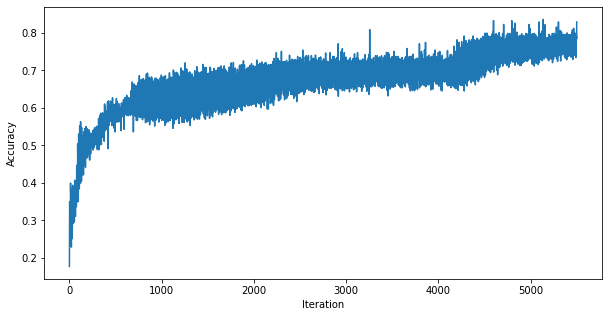

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

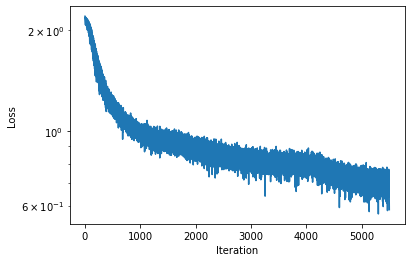

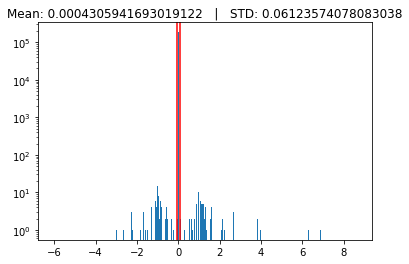

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.705882352941177


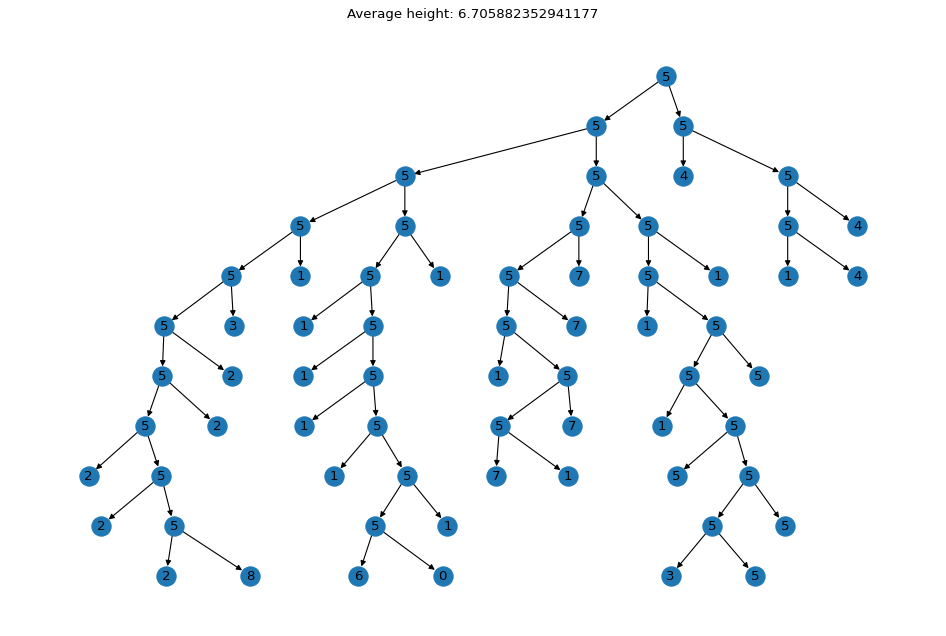

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 34


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()